<a href="https://colab.research.google.com/github/Izeple/Image-Captioning-Senior-Project/blob/master/imageC_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

keras https://www.kaggle.com/wikiabhi/image-caption-generator <br>
tensorflow  https://www.kaggle.com/hsankesara/image-captioning

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/


# 1. Setup

## Import library

In [ ]:
import string
import pandas as pd
import os
import glob
from pickle import dump, load
from IPython.display import Image, display
import matplotlib.pyplot as plt
import time
import numpy as np
import glob
import random    
import re

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, GRU
from keras.layers import RepeatVector,TimeDistributed
from keras.layers import Concatenate,Activation
from keras.optimizers import Adam,RMSprop

#keras-self-attention         #https://pypi.org/project/keras-self-attention/
!pip -q install keras-self-attention
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

#Keras Attention & AdditiveAttention
from keras.layers import Attention            #Attention() layers, implementing Luong attention.
from keras.layers import AdditiveAttention    #AdditiveAttention() layers, implementing Bahdanau attention.

# small library for seeing the progress of loops.
#from tqdm.notebook import tqdm as tqdm        #from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

In [ ]:
# remove all file in dir
#!rm -rfv ./pic

# unzip
#!unzip pic.zip

## Connect colab with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/SeniorProject"

Mounted at /content/drive
/content/drive/MyDrive/SeniorProject


# 2. Prepare Photo Data

## List all name picture in directory
โหลดชื่อรูปภาพทั้งหมดเก็บใส่เข้าไปใน list

In [ ]:
#images_list = os.listdir('./pic/')
#dump(images_list, open("./pickle/images_list.pkl", "wb"))    # save images_list.pkl
images_list = load(open("./pickle/images_list.pkl", "rb"))   # load images_list.pkl
len(images_list)

34491

## Extract features by Xception

### Plot the model architecture

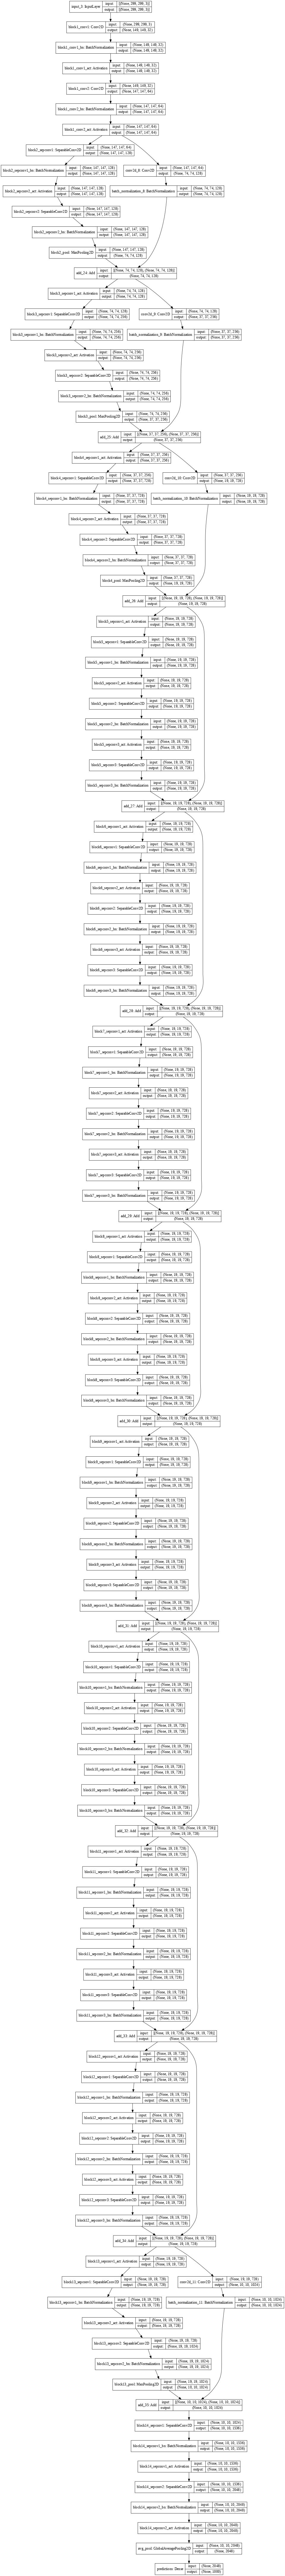

In [ ]:
# Plot the model architecture
plot_model(Xception(), to_file='./model_pic/Xception.png', show_shapes=True,dpi=60)

### Create features_xception.pkl

In [ ]:
# Xception
def extract_features_xception(directory,start,stop):
    model = Xception( include_top=False, pooling='avg')
    features = {}
    list_dir = os.listdir(directory)
    for img in list_dir[start:stop]:
        filename = directory + "/" + img
        try:
            image = load_img(filename, target_size=(299, 299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
        except Exception:
            pass
        
        feature = model.predict(image)
        features[img] = feature
    return features

In [ ]:
# get feature by xception
for i in range(0,len(images_list),1000):                                                   # แบ่งเทรนทีละ 1000 เพราะว่า ทำทีเดียว 28000 เจอปัญหาเยอะ เช่น timeout, memmoryเต็ม
    print(i,i+1000)
    features = extract_features_xception(directory,i,i+1000)
    dump(features, open('./features_xception/features_xception_'+str(i)+'.p', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle

"\ndirectory = './pic/'\n\ntrain_images_list = os.listdir(directory)\nfor i in range(0,len(train_images_list),1000):                # แบ่งเทรนทีละ 1000 เพราะว่า ทำ 28000 เจอปัญหาเยอะ timeout, memmoryเต็ม\n    print(i,i+1000)\n    features = extract_features_xception(directory,i,i+1000)\n    dump(features, open('./features_xception/features_xception_'+str(i)+'.p', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle\nprint('Extracted Features: ', len(features))\n"

In [ ]:
# load *.pkl and merge to features_xception.pkl
features_xception = {}
for filename in glob.glob('./features_xception/*.p'):
    with open(filename, 'rb') as f:
      d = pickle.load(f)
    features_xception.update(d)

dump(features_xception, open('./pickle/features_xception.pkl', 'wb'))
len(features_xception)

"\nfeatures_xception = {}\nfor filename in glob.glob('./features_xception/*.p'):\n    with open(filename, 'rb') as f:\n      d = pickle.load(f)\n    features_xception.update(d)\n\ndump(features_xception, open('./pickle/features_xception.pkl', 'wb'))\nlen(features_xception)\n"

### Load features_xception.pkl

In [ ]:
# load features_xception.pkl       เนื่องจาก　การทำ features extraction ใช้เวลานาน จึงได้ทำการเทรนwไว้ก่อนแล้ว แล้วเก็บเป็น ไฟล์ .pkl พร้อมโหลดมาใช้งานได้ตลอด
features_xception = load(open("./pickle/features_xception.pkl","rb"))
len(features_xception)

34491

## Extract features by VGG

### Plot the model architecture

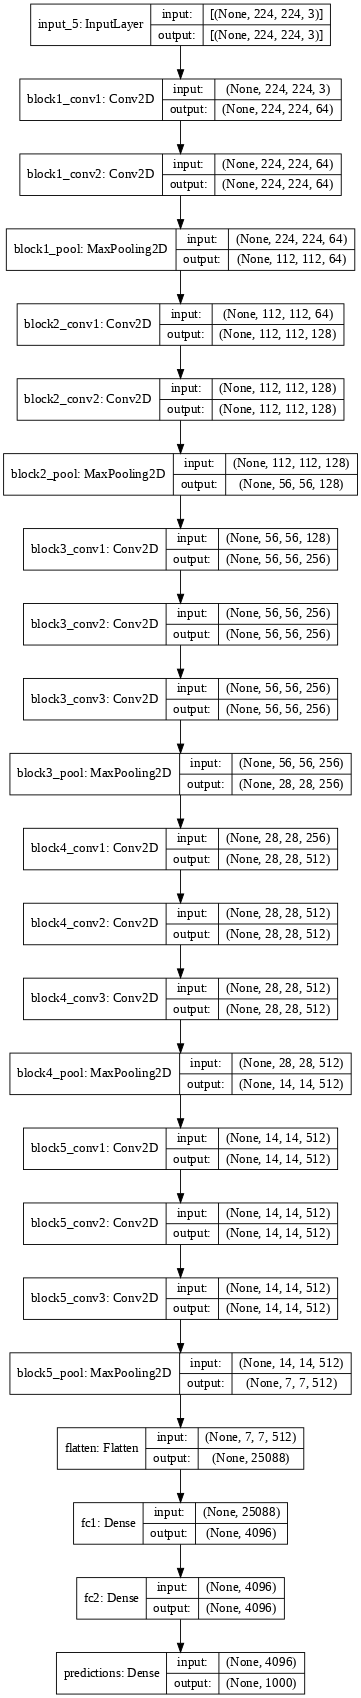

In [ ]:
# Plot the model architecture
plot_model(VGG16(), to_file='./model_pic/VGG.png', show_shapes=True, dpi=65)

### Create features_vgg.pkl

In [ ]:
# Extract features from each photo in the directory
def extract_features_vgg(directory,start,stop):
    model = VGG16()       
    model.layers.pop()                                                              # ลบเลเยอร์สุดท้ายที่เป็น classification ออก 
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)             # แล้วจะกลายเป็นโมเดล encoder ที่สร้าง features ของรูปภาพ
    list_dir = os.listdir(directory)

    features = dict()                                                               # สร้าง features ให้เป็น dictionary
    for name in list_dir[start:stop]:
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))                          # โหลดรูปแล้วแปลงให้มีขนาด 224*224
        image = img_to_array(image)                                                 # แปลงจาก pixels ให้เป็น numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # reshape ให้พร้อมเข้าโมเดล
        image = preprocess_input(image)                                             # เป็น preprocess สำเร็จรูปของ VGG  
        feature = model.predict(image, verbose=0)                                   # ให้โมเดล สร้าง features ออกมา
        image_id = name.split('.')[0]                                               # เอาชื่อไฟล์ภาพ มาเป็น key ของ features 
        features[image_id] = feature
    return features

In [ ]:
# get feature by vgg
for i in range(0,len(images_list),1000):                                           # แบ่งเทรนทีละ 1000 แล้ว save .pkl เพราะว่า ทำทีเดียว 28000 จะเจอปัญหาเยอะ timeout, memmory เต็ม
    print(i,i+1000)
    features = extract_features_vgg(directory,i,i+1000)
    dump(features, open('./features_vgg/features_vgg_'+str(i)+'.pkl', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000


In [ ]:
# load *.pkl　from dir_load and then merge it save to dir_save
def merge_pkl(dir_load,dir_save):
    pkl_file = {}
    for filename in glob.glob(dir_load):
        with open(filename, 'rb') as f:
          d = load(f)
        pkl_file.update(d)

    dump(pkl_file, open(dir_save, 'wb'))
    print(len(pkl_file))

In [ ]:
merge_pkl(dir_load='./features_vgg/features_vgg_*.pkl', dir_save='./features_vgg.pkl')

### Load features_vgg.pkl 

In [ ]:
# load features_vgg.pkl       เนื่องจาก　การทำ features extraction ใช้เวลานาน จึงได้ทำการเทรนwไว้ก่อนแล้ว แล้วเก็บเป็น ไฟล์ .pkl พร้อมโหลดมาใช้งานได้ตลอด
features_vgg = load(open("./pickle/features_vgg.pkl","rb"))
len(features_vgg)

34491

## Extract features by ResNet50

### Plot the model architecture

102973440/102967424 [==============================] - 1s 0us/step


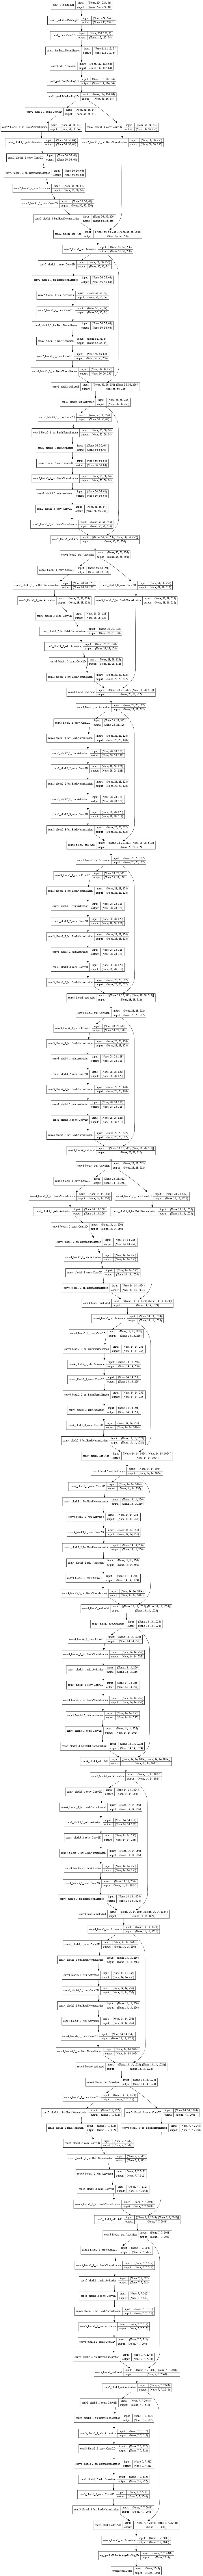

In [ ]:
# Plot the model architecture
plot_model(ResNet50(), to_file='./model_pic/ResNet50.png', show_shapes=True,dpi=60)

### Create features_resnet50.pkl

In [ ]:
# Extract features from each photo in the directory
def extract_features_resnet50(directory,start,stop):
    model = ResNet50(include_top=False, pooling='avg')
    features = {}
    list_dir = os.listdir(directory)
    for img in list_dir[start:stop]:
        filename = directory + "/" + img
        try:
            image = load_img(filename, target_size=(299, 299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
        except Exception:
            pass
        
        feature = model.predict(image)
        features[img] = feature
    return features

In [ ]:
# get feature by xception
for i in range(0,len(images_list),1000):                                                   # แบ่งเทรนทีละ 1000 เพราะว่า ทำทีเดียว 28000 เจอปัญหาเยอะ เช่น timeout, memmoryเต็ม
    print(i,i+1000)
    features = extract_features_resnet50(directory,i,i+1000)
    dump(features, open('./features_resnet50/features_resnet50_'+str(i)+'.p', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle

0 1000
94773248/94765736 [==============================] - 1s 0us/step
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000


In [ ]:
# load *.pkl and merge to features_resnet50.pkl
features_resnet50 = {}
for filename in glob.glob('./features_resnet50/*.p'):
    with open(filename, 'rb') as f:
      d = load(f)
    features_resnet50.update(d)

dump(features_resnet50, open('./pickle/features_resnet50.pkl', 'wb'))
len(features_resnet50)

34491

## เสริม
https://github.com/HyunJu1/Image-Captioning/blob/master/Image%20Captioning.ipynb

In [ ]:
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.applications.resnet50  import ResNet50
image_model = VGG16(include_top=True, weights='imagenet')
image_model = InceptionV3(include_top=True, weights='imagenet')
image_model = ResNet50(include_top=True, weights='imagenet')
image_model.summary()


# vgg 16일 때
#transfer_layer = image_model.get_layer('fc2')

# Inception V3 & RESNET 50 일 때 
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

img_size = K.int_shape(image_model.input)[1:3]
print(img_size)

transfer_values_size = K.int_shape(transfer_layer.output)[1]
print(transfer_values_size)

In [ ]:
def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [ ]:
optimizer = RMSprop(lr=1e-3)

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

# 3. Prepare text Data

In [ ]:
engine = "newmm-safe"
folder = "/hand_newmm-safe"

## 3.1 Load and Merge df.csv 

In [ ]:
def get_merged_csv(flist, **kwargs):
    return pd.concat([pd.read_csv(f, **kwargs) for f in flist], axis=0)

In [ ]:
path = "./df_/"
fmask = os.path.join(path, 'df_description*.csv')
dd = get_merged_csv(glob.glob(fmask))
print(dd.shape)
dd.head()

(283294, 4)


URL  ... Unnamed: 0
0  https://portal.weloveshopping.com/product/L900...  ...        NaN
1  https://portal.weloveshopping.com/product/L900...  ...        NaN
2  https://portal.weloveshopping.com/product/L900...  ...        NaN
3  https://portal.weloveshopping.com/product/L900...  ...        NaN
4  https://portal.weloveshopping.com/product/L900...  ...        NaN

[5 rows x 4 columns]

In [ ]:
path = "./df_/"
fmask = os.path.join(path, 'df_list*.csv')
dl = get_merged_csv(glob.glob(fmask))
print(dl.shape)
dl.head()

(53348, 3)


Unnamed: 0                                                URL Catagory
0           0  https://portal.weloveshopping.com/product/L917...      NaN
1           1  https://portal.weloveshopping.com/product/L917...      NaN
2           2  https://portal.weloveshopping.com/product/L917...      NaN
3           3  https://portal.weloveshopping.com/product/L917...      NaN
4           4  https://portal.weloveshopping.com/product/L917...      NaN

### Join & Drop columns "index" or "Unnamed: 0"

In [ ]:
dl.drop(columns=["index","Unnamed: 0"],errors="ignore",inplace=True)
dd.drop(columns=["index","Unnamed: 0"],errors="ignore",inplace=True)

df = dl.set_index("URL").join(dd.set_index("URL"))
print("Total row : ",df.shape[0])
df.head()

Total row :  437990


Catagory  ...                                        description
URL                                                          ...                                                   
https://portal.weloveshopping.com/product/L9000...      NaN  ...  เคส ซัมซุง Samsung Galaxy Note 3 Note III N900...
https://portal.weloveshopping.com/product/L9000...      NaN  ...            สินค้าคุณภาพจาก CheekKa Store น่ารักค่ะ
https://portal.weloveshopping.com/product/L9000...      NaN  ...  สีของสินค้าอาจมี ความคลาดเคลื่อนเล็กน้อยอยู่ที...
https://portal.weloveshopping.com/product/L9000...      NaN  ...                              ขอบคุณที่มาอุดหนุนค่ะ
https://portal.weloveshopping.com/product/L9000...      NaN  ...  เคส Samsung Galaxy S5 i9600 Case วิบวับ ลายผสม...

[5 rows x 3 columns]

### Characteristics Dataframe

In [ ]:
df_c_url = df.reset_index().groupby("URL").count()
df_c_catagory = df.reset_index().groupby("Catagory").count()
print("Number of Items in dataframe \t\t: ",df_c_url.shape[0])
print("Number of Catagories in dataframe \t: ",df_c_catagory.shape[0])
print("Max descrition rows in one item \t: ",df_c_url.sort_values("Catagory",ascending=False).iloc[0,0])
print("\nCatagory : ",df_c_catagory.index.values)

Number of Items in dataframe 		:  40916
Number of Catagories in dataframe 	:  16
Max descrition rows in one item 	:  592

Catagory :  ['กล้อง-23' 'ชุดเดรส-1342' 'นาฬิกา-152' 'น้ำหอม-764'
 'ผลิตภัณฑ์ดูแลผิวหน้า-1396' 'ยานพาหนะและอุปกรณ์ตกแต่ง-12'
 'สวนและสนามหญ้า-241' 'ห้องน้ำ-1567' 'อาหารและเครื่องดื่ม-15'
 'อุปกรณ์สำหรับแม่และเด็กหลังคลอด-864' 'เมมโมรี่การ์ด-254'
 'เสื้อผู้หญิง-1341' 'เสื้อผ้าเด็ก+เครื่องแต่งกายเด็ก-1814'
 'แก็ดเจ็ต-1793' 'แหวน-708' 'โรงงานและอุตสาหกรรม-1550']


### Drop columns "src","Catagory"

In [ ]:
df.drop(columns=["src","Catagory"],errors="ignore",inplace=True)

### Reduce URL to code product

In [ ]:
df.reset_index(inplace=True)
df["URL"] = df["URL"].apply(lambda x:x.replace("https://portal.weloveshopping.com/product/","")+".jpg")
df.head()

URL                                        description
0  L90000276.jpg  เคส ซัมซุง Samsung Galaxy Note 3 Note III N900...
1  L90000276.jpg            สินค้าคุณภาพจาก CheekKa Store น่ารักค่ะ
2  L90000276.jpg  สีของสินค้าอาจมี ความคลาดเคลื่อนเล็กน้อยอยู่ที...
3  L90000276.jpg                              ขอบคุณที่มาอุดหนุนค่ะ
4  L90000469.jpg  เคส Samsung Galaxy S5 i9600 Case วิบวับ ลายผสม...

In [ ]:
# random pic & description
rand = random.randint(0,len(df))
print(df.URL[rand])
df[df.URL==df.URL[rand]] 

L91215422.jpg


URL                              description
171114  L91215422.jpg  TOYOTA FRONT & TURN SIGNAL LIGHTS LN40Y
171115  L91215422.jpg                              ราคาต่อคู่ 
171116  L91215422.jpg                                         
171117  L91215422.jpg                                         
171118  L91215422.jpg                                         
...               ...                                      ...
171217  L91215422.jpg                                         
171218  L91215422.jpg                                         
171219  L91215422.jpg                                         
171220  L91215422.jpg                                         
171221  L91215422.jpg                                         

[108 rows x 2 columns]

## 3.2 Text cleaning

### DropNa

In [ ]:
df_row0 = df.shape[0]

In [ ]:
df_row = df.shape[0]
df.dropna(inplace=True)
print("drop na : "+str(df_row - df.shape[0]))
print("drop na : "+str((df_row - df.shape[0])/df_row0*100),"%")

drop na : 15739
drop na : 3.59346103792324 %


### Drop duplicates

In [ ]:
df_row = df.shape[0]
df.drop_duplicates(inplace=True)
print("drop duplicates : "+str(df_row - df.shape[0]))
print("drop duplicates : "+str((df_row - df.shape[0])/df_row0*100)," %")

drop duplicates : 239493
drop duplicates : 54.68001552546862  %


### Replace

In [ ]:
'''
replace_list = ["=-","- ","-"]
for re in replace_list:
    df['description'].replace(re,"",inplace=True)

print("df row remain : ",df.shape[0])
'''

'\nreplace_list = ["=-","- ","-"]\nfor re in replace_list:\n    df[\'description\'].replace(re,"",inplace=True)\n\nprint("df row remain : ",df.shape[0])\n'

### Drop word

In [ ]:
#df[~df['description'].isin(droplist)].shape
df_keep = df.copy()
print_drop = []

droplist = ["ราคา","แนะนำสินค้า","รายละเอียดสินค้า","วิธีใช้งาน","ข้อมูลทางเทคนิค","คุณสมบัติ",
              "จัดส่งฟรีทั่วประเทศ","รหัส","ไซส์","แบรนด์แท้","นำเข้าจาก","ขอบคุณ","เงื่อนไข",
            "สินค้าพร้อมส่ง","สินค้าเข้าใหม่จ้า","สินค้ามาใหม่จ้า","สินค้ามีคุณภาพ","สินค้าพรีออเดอร์",
            "คำแนะนำ","ยินดีบริการ","สภาพใหม่","สภาพดี","การจัดส่งกลับ","ส่งฟรีลงทะเบียน",
            "รายการนี้","กดสั่งซื้อแล้วยกเลิกขออนุญาต","ลดแล้วลดอีก","สินค้าบรรจุในซองกันกระแทก",
            "โดยไปรษณีย์ลงทะเบียน","วิธีดูแลรักษา","ลูกค้ากรุณา","สอบถามสินค้า","วิธีใช้","พร้อมส่ง","สั่งได้"
           ]

droplist_o = ["ราคา","แนะนำสินค้า","นะนำสินค้า","จัดส่งฟรีทั่วประเทศ","รหัส","ไซส์",
            "Email","size :","Detail","NEW","(new)","Brand","Welcome","Input","output","Price",
            "Please","Pre-Order","Quilla Korean Plus","N E W",
            "แบรนด์แท้ นำเข้าจาก shop","ขอบคุณ","เงื่อนไข",
            "ข้อมูลทางเทคนิค","คุณสมบัติ","วิธีใช้งาน",
            "สินค้าพร้อมส่ง","สินค้าเข้าใหม่จ้า","สินค้ามาใหม่จ้า","สินค้ามีคุณภาพ","สินค้าพรีออเดอร์",
            "รายละเอียดสินค้า","เเนะนำสินค้า","คำแนะนำ",
            "ยินดีบริการ","สภาพใหม่","สภาพดี","การจัดส่งกลับ","ส่งฟรีลงทะเบียน","รายการนี้",
            "กดสั่งซื้อแล้วยกเลิกขออนุญาต","ลดแล้วลดอีก","สินค้าบรรจุในซองกันกระแทก",
            "โดยไปรษณีย์ลงทะเบียน","วิธีดูแลรักษา","ลูกค้ากรุณา","สอบถามสินค้า","วิธีใช้"
           ]
#,"\u0e"
dropfirst = [" "]
df_drop = pd.DataFrame()

for drop in droplist:
    old = df_keep.shape[0]
    
    #keep the row will drop in df_drop
    df_drop_temp = df_keep[df_keep.description.str.contains(drop, regex=True) == True]
    df_drop_temp["drop"] = drop
    df_drop = pd.concat([df_drop,df_drop_temp],axis=0)
    
    df_keep = df_keep[df_keep.description.str.contains(drop, regex=True) == False]
    print_drop.append([drop,(old-df_keep.shape[0])])
    #print("{0:<15} {1:<10}".format(drop, str(old-df_keep.shape[0])))
    
#for drop in dropfirst:
#    old = df_keep.shape[0]
#    df_keep = df_keep[df_keep.description.str.startswith(drop) == False]
#    print_drop.append([drop,(old-df_keep.shape[0])])

#to_drop = ['Clerk', 'Bagger']
#df[~df['title'].isin(to_drop)]
print(df_keep.shape)
pd.DataFrame(print_drop,columns=["drop","count"]).sort_values(by="count", ascending=False).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(161641, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drop  count
0                        ราคา   4706
5                   คุณสมบัติ   4288
8                        ไซส์   2294
33                   พร้อมส่ง   1931
7                        รหัส   1382
2            รายละเอียดสินค้า   1070
12                   เงื่อนไข    845
32                    วิธีใช้    754
1                 แนะนำสินค้า    702
4             ข้อมูลทางเทคนิค    513
31               สอบถามสินค้า    336
30                ลูกค้ากรุณา    315
11                     ขอบคุณ    298
10                  นำเข้าจาก    293
29              วิธีดูแลรักษา    252
13             สินค้าพร้อมส่ง    204
6         จัดส่งฟรีทั่วประเทศ    165
17           สินค้าพรีออเดอร์    134
27  สินค้าบรรจุในซองกันกระแทก     99
22              การจัดส่งกลับ     99

In [ ]:
#save 
#df_drop.reset_index()[["drop","description"]].to_csv('df_drop.csv',encoding='utf-8-sig')

### Drop empty row

In [ ]:
row0 = df_keep.shape[0]
df_keep = df_keep[df_keep["description"]!=""]
df_keep = df_keep[df_keep["description"]!=" "]
print("drop : ",row0-df_keep.shape[0])
print("remain : ",df_keep.shape[0])

drop :  1596
remain :  160045


### Number of Description duplicate

In [ ]:
print("total row :",df_keep.shape[0])
print("total item :",df_keep.reset_index().groupby('URL',as_index=False).size().shape[0])
print("max row in one item :",df_keep.reset_index().\
      groupby('URL',as_index=False).size().sort_values(by="size", ascending=False).iloc[0,1])

df_keep.groupby('description',as_index=False).size().sort_values(by="size", ascending=False)

total row : 160045
total item : 30134
max row in one item : 136


description  size
41570  กระจกนิรภัยโฟกัส (FOCUS TEMPERED GLASS) กระจกน...   380
73040                                  อุปกรณ์ภายในกล่อง   319
65063                                      รูปร่าง: แหวน   301
19231              -ล้างเหงื่อและสิ่งสกปรก ด้วยน้ำธรรมดา   272
19459  -หลีกเลี่ยงการขัดอย่างแรงบนเครื่องประดับที่มี่...   271
...                                                  ...   ...
32958  Multipoint Speakerphone ลำโพงบลูทูธเชื่อมต่อมื...     1
32957  Multiple rich moisturizing ingredients hydrate...     1
32956                         Multiple Protection System     1
32954  Multifunctions clip 2 in 1 ตัวหนีบ จับ ยึด สำห...     1
89424                                       �ผลที่ได้รับ     1

[89425 rows x 2 columns]

### Join description with " "

In [ ]:
df_keep.reset_index(inplace=True)
df_keep.drop(columns=["index","Unnamed: 0"],errors="ignore",inplace=True)
df_keep_join = pd.DataFrame(df_keep.groupby(['URL'])['description'].apply(' '.join))
df_keep_join

description
URL                                                             
L90000276.jpg  เคส ซัมซุง Samsung Galaxy Note 3 Note III N900...
L90000469.jpg  เคส Samsung Galaxy S5 i9600 Case วิบวับ ลายผสม...
L90000475.jpg  เคส Samsung Galaxy S5 i9600 Case วิบวับ ไล่เฉด...
L90000672.jpg  เคส ซัมซุง Samsung Galaxy Note 3 Note III N900...
L90003304.jpg  เคส ไอโฟน5 iphone5 5S Case วิบวับ ลาย หัวใจ หว...
...                                                          ...
L91708203.jpg  สบู่มะรุม เหมาะกับทุกสภาพผิว* ลดสิว *ลดฝ้า *กร...
L91708206.jpg  ผงพอกหน้าใบมะรุม สูตรไขสาว ผงใบมะรุม สูตรไขสาว...
L91708210.jpg  ก๊อกน้ำทองเหลือง ก๊อกนักษัตร   แข็งแรง ไม่เป็น...
L91708283.jpg  ผลิตจาก PVC 100% (มีให้เลือกถึง 10 สี ฟ้า/ม่วง...
L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียม มีพนักพิง และ ที่วางแข...

[30134 rows x 1 columns]

## 3.3 Regex

https://stackoverflow.com/questions/38615740/regular-expression-to-accept-all-thai-characters-and-english-letters-in-python

https://stackoverflow.com/questions/38615740/regular-expression-to-accept-all-thai-characters-and-english-letters-in-python

In [ ]:
import re

In [ ]:
pattern = re.compile(r"[^\u0E00-\u0E7F']|^'|'$|''")

In [ ]:
temp = df_keep_join["description"].apply(lambda x:re.findall(pattern, x)).values
unique_list = set()
for t in temp:
  unique_list = unique_list.union(set(t))

' '.join(unique_list)

'u ú � x 问 … ۞ q • 龍 d 1 微 ä 텐 ½ \\ . ஜ r " ī ◡ 미 p 〝 3 Ⅱ U 长 9 라 n 어 Ó L 中 存 j 误 ▬ Ē □ c [ ﾟ O © ク a P 动 Ø k : ◦ 트 ： 、 ｡ B ] ® W Δ ► ¼ ¥ ! ꫛ 辛 ⌚ ε 衣 이 S ¸ − 6 \u202a z ل 非 提 w 。 上 ラ ‰ ≈ 米 ▪ 花 收 ا 삼 并 \u200e ó ¯ 尺 ∞ M & 케 ス ː > h ダ % ( 同 日 $ ° ï — ッ プ ト ㆍ ; ； , - （ 산 \u202c 围 Ω y l ⃣ ″ t 拍 ▶ – Z   v ℉ ン 与 0 表 ā ） \'\' 童 ↔ / G 鹅 Î 年 o φ エ R 绒 法 ● ꪝ ･ ꫀ I X ^ ɸ Ï ■ | ´ 7 인 ¤ 세 ) ح 儿 · ⁰ ⌛ ～ 에 성 ア 8 μ ⭐ H ™ ə 不 馨 θ 运 ‑ 腰 质 < î ॐ 能 题 イ ジ ≥ 实 갈 セ í ⏩ ø 梅 림 チ ▷ á 스 ー ƒ Q \' g ر * 菊 ∼ 토 É 的 @ \xad = ç 2 ℃ µ レ ì 车 락 可 ط ۩ Ô 】 º C é ‼ 【 ％ 物 5 ∮ グ ️ s × ÷ # 测 本 » 》 您 _ T Y ＜ 示 ? 胸 + 대 カ ⁉ ‿ 方 N ò E ポ ღ } \uf076 K ◀ ・ ＃ ˚ J \u202d e 酒 크 裤 \uf06c V 센 因 差 ㎛ 天 √ 4 i 頭 ` f F A → è ？ 袖 码 ³ 解 ◕ D ~ 温 ع ※ ‐ ￼ b 和 〃 ⠀ ب m 理 م ⬇ ô 血 ， ë ル 在 ± 量 ≤ 小 请 清 到 {'

In [ ]:
df_keep_join["description"] = df_keep_join["description"].apply(lambda x:''.join([char for char in x if not char in unique_list]))
df_keep_join

description
URL                                                             
L90000276.jpg  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...
L90000469.jpg  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...
L90000475.jpg  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...
L90000672.jpg  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...
L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...
...                                                          ...
L91708203.jpg  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...
L91708206.jpg  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...
L91708210.jpg  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...
L91708283.jpg  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...
L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...

[30134 rows x 1 columns]

In [ ]:
# save
#dump(df_keep_join, open("./pickle/data/df_keep_join.pkl","wb"))
#df_keep_join.to_csv("./csv/data/df_keep_join.csv",encoding='utf-8-sig')

### add image list

In [ ]:
#images_list = os.listdir('./pic/')
images_list = load(open("./pickle/images_list.pkl", "rb"))   # load images_list.pkl
print(len(images_list))

34491


In [ ]:
temp = df_keep_join.copy()
union_index = list(set(temp.index.values).union(set(images_list)))
df_keep_join_union = temp.reindex(union_index)

In [ ]:
df_keep_join_union.sort_index(inplace=True)

In [ ]:
# save
df_keep_join_union.to_csv("./csv/df_description_data.csv",encoding='utf-8-sig')
df_keep_join_union

description
URL                                                             
L90000276.jpg  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...
L90000469.jpg  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...
L90000475.jpg  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...
L90000672.jpg  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...
L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...
...                                                          ...
L91708203.jpg  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...
L91708206.jpg  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...
L91708210.jpg  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...
L91708283.jpg  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...
L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...

[37069 rows x 1 columns]

## Load Data ver.

In [ ]:
df_ex = pd.read_csv("./csv/df_description_data.csv")
df_ex

URL                                        description
0      L90000276.jpg  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...
1      L90000469.jpg  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...
2      L90000475.jpg  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...
3      L90000672.jpg  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...
4      L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...
...              ...                                                ...
37064  L91708203.jpg  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...
37065  L91708206.jpg  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...
37066  L91708210.jpg  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...
37067  L91708283.jpg  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...
37068  L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...

[37069 rows x 2 columns]

## Load Hand ver. 

In [ ]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [ ]:
df_hand = pd.read_csv("./csv/df_description_hand.csv")
df_hand

URL                                        description
0     L90000276.jpg  เคสซัมซุงสีฟ้าลายแถบสีเหลืองใส่พอดี, เคสมือถือ...
1     L90000469.jpg  เคสวิบวับมุกสีชมพูใส่พอดี, เคสมือถือลายไข่มุกส...
2     L90000475.jpg  เคสวิบวับไล่เฉดสีชมพู, เคสมือถือลายเพชรสีชมพู,...
3     L90000672.jpg  เคสซัมซุงลายดาวสีขาวดำ, เคสมือถือลายดาวสีขาวดำ...
4     L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวาน, เคสมือถือลายหัวใจห...
...             ...                                                ...
5720  L91687085.jpg  สายชาร์จมือถือสีดำ, สายชาร์จมือถือไลท์นิ่ง, สา...
5721  L91687086.jpg  สายชาร์จมือถือสีดำ, สายชาร์จมือถือไลท์นิ่ง, สา...
5722  L91687087.jpg  สายชาร์จมือถือสีดำ, สายชาร์จมือถือไลท์นิ่ง, สา...
5723  L91687089.jpg  สายชาร์จมือถือสีดำ, สายชาร์จมือถือไลท์นิ่ง, สา...
5724  L91687090.jpg  หัวอะแดปเตอร์ชาร์จสีดำ, หัวปลั๊กชาร์จยูเอสบีสี...

[5725 rows x 2 columns]

In [ ]:
df_ex = explode(df_hand.assign(description=df_hand.description.str.split(',')), 'description')
df_ex

URL                          description
0      L90000276.jpg  เคสซัมซุงสีฟ้าลายแถบสีเหลืองใส่พอดี
1      L90000276.jpg      เคสมือถือลายสีฟ้ากับแถบสีเหลือง
2      L90000276.jpg    เคสมือถือลายสีฟ้าและมีแถบสีเหลือง
3      L90000469.jpg            เคสวิบวับมุกสีชมพูใส่พอดี
4      L90000469.jpg             เคสมือถือลายไข่มุกสีชมพู
...              ...                                  ...
17156  L91687089.jpg               สายชาร์จมือถือไลท์นิ่ง
17157  L91687089.jpg           สายชาร์จมือถือไลท์นิ่งสีดำ
17158  L91687090.jpg               หัวอะแดปเตอร์ชาร์จสีดำ
17159  L91687090.jpg             หัวปลั๊กชาร์จยูเอสบีสีดำ
17160  L91687090.jpg                       ชาร์จเจอร์สีดำ

[17161 rows x 2 columns]

## 3.4 Word tokenization

In [ ]:
!pip -q install pythainlp
!pip -q install deepcut

from pythainlp.tokenize import word_tokenize
from deepcut import tokenize

In [ ]:
#engine = "newmm-safe"
engine = "deepcut"
data = "data"
#data = "hand"
folder = "/"+data+"_"+engine

In [ ]:
tokenization_list = []
for i in range(df_ex.shape[0]):
    tokenization_list.append(word_tokenize(df_ex.iloc[i,1], engine=engine, keep_whitespace=False))

df_ex.reset_index(inplace=True)
df_ex.drop(columns=["index","Unnamed: 0"],errors="ignore",inplace=True)
df_token = pd.DataFrame({'tokenization_list':tokenization_list})
df_join = pd.concat([df_ex,df_token],axis=1)
df_join.set_index("URL",inplace=True)
df_join

description                                  tokenization_list
URL                                                                                                                
L90000276.jpg  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...  [เคสซัมซุง, สี, ฟ้า, มี, ชิ้นด้าน, หลัง, ใส่, ...
L90000469.jpg  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...  [เคสวิบ, วับ, ลาย, ผสม, มุก, สี, ชมพู, มี, ชิ้...
L90000475.jpg  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...  [เคสวิบวับ, ไล่, เฉด, สี, ชมพู, มี, ชิ้นด้าน, ...
L90000672.jpg  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...  [เคสซัมซุง, ลาย, ดาว, มี, ชิ้นด้าน, หลัง, ใส่,...
L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...  [เคสไอ, โฟน, วิบวับ, ลาย, หัวใจ, หวาน, มี, ชิ้...
...                                                          ...                                                ...
L91708203.jpg  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...  [สบู่มะรุมเหมาะ, กับ, ทุก, สภาพ, ผิว, ลด, สิว,...
L91708206.jpg  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...  [ผง, พอกหน้า, ใบ, มะรุม, สูตร, ไข, สาว, ผง, ใบ...
L91708210.jpg  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...  [ก๊อก, น้ำ, ทองเหลือง, ก๊อก, นักษัตร, แข็งแรง,...
L91708283.jpg  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...  [ผลิต, จาก, มี, ให้, เลือก, ถึง, สี, ฟ้า, ม่วง...
L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...  [เก้าอี้, อาบ, น้ำ, อลูมิเนียม, มี, พนักพิง, แ...

[37069 rows x 2 columns]

In [ ]:
dump(df_join, open("./pickle"+folder+"/df_token.pkl","wb"))

## 3.5 add start end in descriptions

In [ ]:
def set_of_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d) for d in descriptions[key]]
    return vocab

def descriptions_add_start_end(description_mapping):
    for key, description in description_mapping.items():
        description_mapping[key] = ["<start>"] + description + ["<end>"]

In [ ]:
df = load(open("./pickle/"+folder+"/df_token.pkl","rb"))
df

description                                  tokenization_list
URL                                                                                                                
L90000276.jpg  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...  [เคสซัมซุง, สี, ฟ้า, มี, ชิ้นด้าน, หลัง, ใส่, ...
L90000469.jpg  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...  [เคสวิบ, วับ, ลาย, ผสม, มุก, สี, ชมพู, มี, ชิ้...
L90000475.jpg  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...  [เคสวิบวับ, ไล่, เฉด, สี, ชมพู, มี, ชิ้นด้าน, ...
L90000672.jpg  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...  [เคสซัมซุง, ลาย, ดาว, มี, ชิ้นด้าน, หลัง, ใส่,...
L90003304.jpg  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...  [เคสไอ, โฟน, วิบวับ, ลาย, หัวใจ, หวาน, มี, ชิ้...
...                                                          ...                                                ...
L91708203.jpg  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...  [สบู่มะรุมเหมาะ, กับ, ทุก, สภาพ, ผิว, ลด, สิว,...
L91708206.jpg  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...  [ผง, พอกหน้า, ใบ, มะรุม, สูตร, ไข, สาว, ผง, ใบ...
L91708210.jpg  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...  [ก๊อก, น้ำ, ทองเหลือง, ก๊อก, นักษัตร, แข็งแรง,...
L91708283.jpg  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...  [ผลิต, จาก, มี, ให้, เลือก, ถึง, สี, ฟ้า, ม่วง...
L91709961.jpg  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...  [เก้าอี้, อาบ, น้ำ, อลูมิเนียม, มี, พนักพิง, แ...

[37069 rows x 2 columns]

In [ ]:
#descriptions = df[["URL","description"]]                 #dataframe
print("Length of descriptions =" ,len(df))

vocabulary = set_of_vocabulary(df[["tokenization_list"]])     #set
print("Length of vocabulary = ", len(vocabulary))         

print("\nVocal : ",end="")
' '.join(vocabulary)

Length of descriptions = 37069
Length of vocabulary =  30489

Vocal : 

'หัวชาร์ นกฮัมมิงเบิร์ด แมงโก้เดรสทรง รีนิวอลดี ไทมมิ่ง มอนสเตอร์ รุปร่าง ซอฟต์แวร์ เชื้อสิว ขนหญ้า มิกิ ดั่งทอง แห่งฝ้า กั้น วัตต์วัตต์ กะรัตแซฟไฟร์สี แอพกล้อง ชุบโครเมี่ยม ขับเคลื่อน เปียกชื้น แว้น สเปรย์ ตีนเป็ด เที่ยบเท่า ทอแต่ง เหลี่ยมเบลเยี่ยม กุดผ้าแก้ว ค่า ตะปู กบ งาจัสมิน ก้ามเบรคล้อหน้า แต่งเพ็ชร ซูมไกล ป้าพิกเปป้าพิก มะมี เมลานินฟื้นบำรุงเซลล์ มอย กระโปรงชีฟอง สำนักงานปกป้อง สุข คาปู คุณห้าม พ ออโต้ หยาดเยิ้ม บานหาก คราว เหลี่ยมเพชร ทั้วๆ สิวเอ็ม ผชลาย เล่น เดรสคอปกติด โลข นาตาลี ส้มเอเลมี กะทัดรัดหัว หางตา การีอควาปูร์ออมโอเดอทอยเลท แอลกอฮอล์ซิลิโคน คอลรอรี่ จำลอง ทอล ซึบซับ หอมปทุมธานี รูปร่าง สม็อคซิป ตาหย่อน แอลกอฮอลสเปรย์ กรมปี มั่มใจ ออกช่อง แขม บูเก้ ชัดเหมาะใน เกาะวัสดุ แง่ พาโกดาซีรีย์ ควน เมตา เกาหลีชิคชิค หรูเนื้อผ้า รูปแบตเตอรี่ ปะทะ ปรจำ กิจวัตร บ้น ไห กระโปรงเสริง หัวคับปลิ้ง ไห่ กล้วยอบเคี้ยว ชายโทรลล์ ชาร์จไอ รองเกลียว เเต่เนื้อ มายเมโลดี้ ฮวด ปลื้ม เรียนรู้ กริตตี้ง เกาะอกเอว โป๊ ศีลธรรม เลือกจ้า ผิวมิล เชียงดา เลส สบายใจ สไป ลาดตระเวน เรื่องราว สดู มกบล๊อก 

In [ ]:
index_list = []
num = 0
for i in df.index:
    num += 1
    index_list.append(i+"_"+str(num))
    if num == 3:
      num = 0
      
print(len(index_list))
index_list[:10]

37069


['L90000276.jpg_1',
 'L90000469.jpg_2',
 'L90000475.jpg_3',
 'L90000672.jpg_1',
 'L90003304.jpg_2',
 'L90003588.jpg_3',
 'L90005040.jpg_1',
 'L90005550.jpg_2',
 'L90007111.jpg_3',
 'L90007587.jpg_1']

In [ ]:
df[["url_list"]] = index_list
df.set_index(["url_list"],inplace=True)
df

description                                  tokenization_list
url_list                                                                                                             
L90000276.jpg_1  เคสซัมซุงสีฟ้ามีชิ้นด้านหลังใส่พอดีกับของคุณสิ...  [เคสซัมซุง, สี, ฟ้า, มี, ชิ้นด้าน, หลัง, ใส่, ...
L90000469.jpg_2  เคสวิบวับลายผสมมุกสีชมพูมีชิ้นด้านหลังใส่พอดีก...  [เคสวิบ, วับ, ลาย, ผสม, มุก, สี, ชมพู, มี, ชิ้...
L90000475.jpg_3  เคสวิบวับไล่เฉดสีชมพูมีชิ้นด้านหลังใส่พอดีกับข...  [เคสวิบวับ, ไล่, เฉด, สี, ชมพู, มี, ชิ้นด้าน, ...
L90000672.jpg_1  เคสซัมซุงลายดาวมีชิ้นด้านหลังใส่พอดีกับของคุณส...  [เคสซัมซุง, ลาย, ดาว, มี, ชิ้นด้าน, หลัง, ใส่,...
L90003304.jpg_2  เคสไอโฟนวิบวับลายหัวใจหวานมีชิ้นด้านหลังใส่พอด...  [เคสไอ, โฟน, วิบวับ, ลาย, หัวใจ, หวาน, มี, ชิ้...
...                                                            ...                                                ...
L91708203.jpg_3  สบู่มะรุมเหมาะกับทุกสภาพผิวลดสิวลดฝ้ากระชับรูข...  [สบู่มะรุมเหมาะ, กับ, ทุก, สภาพ, ผิว, ลด, สิว,...
L91708206.jpg_1  ผงพอกหน้าใบมะรุมสูตรไขสาวผงใบมะรุมสูตรไขสาวกำจ...  [ผง, พอกหน้า, ใบ, มะรุม, สูตร, ไข, สาว, ผง, ใบ...
L91708210.jpg_2  ก๊อกน้ำทองเหลืองก๊อกนักษัตรแข็งแรงไม่เป็นเชื้อ...  [ก๊อก, น้ำ, ทองเหลือง, ก๊อก, นักษัตร, แข็งแรง,...
L91708283.jpg_3  ผลิตจากมีให้เลือกถึงสีฟ้าม่วงเขียวมิ้นเทาควันด...  [ผลิต, จาก, มี, ให้, เลือก, ถึง, สี, ฟ้า, ม่วง...
L91709961.jpg_1  เก้าอี้อาบน้ำอลูมิเนียมมีพนักพิงและที่วางแขนเก...  [เก้าอี้, อาบ, น้ำ, อลูมิเนียม, มี, พนักพิง, แ...

[37069 rows x 2 columns]

In [ ]:
dict_descriptions = df['tokenization_list'].to_dict()
print('L90000276.jpg :',dict_descriptions['L90000276.jpg_1'])

descriptions_add_start_end(dict_descriptions)
print('L90000276.jpg :',dict_descriptions['L90000276.jpg_1'])

L90000276.jpg : ['เคสซัมซุง', 'สี', 'ฟ้า', 'มี', 'ชิ้นด้าน', 'หลัง', 'ใส่', 'พอดี', 'กับ', 'ของ', 'คุณ', 'สินค้า', 'คุณภาพ', 'จาก', 'น่า', 'รัก', 'ค่ะ', 'สี', 'ของ', 'สินค้า', 'อาจ', 'มี', 'ความ', 'คลาดเคลื่อน', 'เล็กน้อย', 'อยู่', 'ที่', 'การ', 'ตั้ง', 'ค่า', 'หน้า', 'จอ', 'คอมพิวเตอร์', 'และ', 'แสง', 'จาก', 'การ', 'ถ่าย', 'ภาพ', 'ค่ะ', 'ถ้าหาก', 'สั่ง', 'สินค้า', 'แบบ', 'สี', 'สัน', 'สี', 'จะ', 'สดใส', 'ปิ๊ง', 'ปั๊ง', 'นิดนึง', 'นะ', 'คะ']
L90000276.jpg : ['<start>', 'เคสซัมซุง', 'สี', 'ฟ้า', 'มี', 'ชิ้นด้าน', 'หลัง', 'ใส่', 'พอดี', 'กับ', 'ของ', 'คุณ', 'สินค้า', 'คุณภาพ', 'จาก', 'น่า', 'รัก', 'ค่ะ', 'สี', 'ของ', 'สินค้า', 'อาจ', 'มี', 'ความ', 'คลาดเคลื่อน', 'เล็กน้อย', 'อยู่', 'ที่', 'การ', 'ตั้ง', 'ค่า', 'หน้า', 'จอ', 'คอมพิวเตอร์', 'และ', 'แสง', 'จาก', 'การ', 'ถ่าย', 'ภาพ', 'ค่ะ', 'ถ้าหาก', 'สั่ง', 'สินค้า', 'แบบ', 'สี', 'สัน', 'สี', 'จะ', 'สดใส', 'ปิ๊ง', 'ปั๊ง', 'นิดนึง', 'นะ', 'คะ', '<end>']


In [ ]:
def merge_dict(df_dict):
  new_dict = dict()
  for key,value in df_dict.items():
    if key.split("_")[0] not in new_dict.keys():
        new_dict[key.split("_")[0]] = [value]
    else:
        new_dict[key.split("_")[0]].append(value)
  return new_dict

In [ ]:
new_dict = merge_dict(dict_descriptions)
new_dict

{'L90000276.jpg': [['<start>',
   'เคสซัมซุง',
   'สี',
   'ฟ้า',
   'มี',
   'ชิ้นด้าน',
   'หลัง',
   'ใส่',
   'พอดี',
   'กับ',
   'ของ',
   'คุณ',
   'สินค้า',
   'คุณภาพ',
   'จาก',
   'น่า',
   'รัก',
   'ค่ะ',
   'สี',
   'ของ',
   'สินค้า',
   'อาจ',
   'มี',
   'ความ',
   'คลาดเคลื่อน',
   'เล็กน้อย',
   'อยู่',
   'ที่',
   'การ',
   'ตั้ง',
   'ค่า',
   'หน้า',
   'จอ',
   'คอมพิวเตอร์',
   'และ',
   'แสง',
   'จาก',
   'การ',
   'ถ่าย',
   'ภาพ',
   'ค่ะ',
   'ถ้าหาก',
   'สั่ง',
   'สินค้า',
   'แบบ',
   'สี',
   'สัน',
   'สี',
   'จะ',
   'สดใส',
   'ปิ๊ง',
   'ปั๊ง',
   'นิดนึง',
   'นะ',
   'คะ',
   '<end>']],
 'L90000469.jpg': [['<start>',
   'เคสวิบ',
   'วับ',
   'ลาย',
   'ผสม',
   'มุก',
   'สี',
   'ชมพู',
   'มี',
   'ชิ้นด้าน',
   'หลัง',
   'ใส่',
   'พอดี',
   'กับ',
   'ของ',
   'คุณ',
   'สินค้า',
   'คุณภาพ',
   'จาก',
   'น่า',
   'รัก',
   'ค่ะ',
   'สี',
   'ของ',
   'สินค้า',
   'อาจ',
   'มี',
   'ความ',
   'คลาดเคลื่อน',
   'เล็กน้อย',
   'อยู่',
  

## get train_descriptions

In [ ]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
    
#images_list = os.listdir('./train2017/')
train_images_list = intersection(list(new_dict.keys()), images_list)  #list(dict_descriptions.keys()
train_images_list = intersection(list(features_xception.keys()), train_images_list)
print("dict image :",len(new_dict.keys()))
print("feature image :",len(list(features_xception.keys())))
print("file image :",len(images_list))
print("train image :",len(train_images_list))

# save
dump(train_images_list, open("./pickle"+folder+"/train_images_list.pkl", "wb"))

# load
train_images_list = load(open("./pickle"+folder+"/train_images_list.pkl","rb"))
print("train image :",len(train_images_list))

In [ ]:
train_descriptions = dict()
for key in train_images_list:
  if len(new_dict[key])>=1:   #3
      train_descriptions[key] = new_dict[key]

len(train_descriptions)

34491

In [ ]:
# save
dump(train_descriptions, open("./pickle/"+folder+"/train_descriptions.pkl", "wb"))

## Random Show

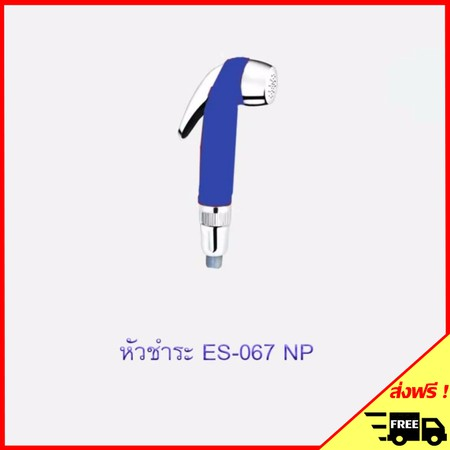

['<start>', 'หัวชำระ', 'รุ่น', 'หัว', 'ฉีด', 'ชำระ', 'ผลิต', 'จาก', 'คุณภาพ', 'ดี', 'แข็งแรง', 'ดีไชน์', 'ทัน', 'สมัย', 'ที่', 'จับ', 'กระชับ', 'มือ', 'ก้าน', 'กด', 'แข็งแรง', 'ไม่', 'หัก', 'ง่าย', 'นำ', 'ไป', 'ชุบ', 'โครเมี่ยม', 'เพื่อ', 'เพิม', 'ความ', 'สวย', 'งาน', 'ติดตั้ง', 'ง่าย', 'ใช้', 'กับ', 'สาย', 'ฝักบัว', 'หรือ', 'สาย', 'ชำระ', 'ได้', 'ทุก', 'รุ่น', '<end>']


In [ ]:
#from IPython.display import Image, display
rand = random.randint(0,len(train_images_list))
display(Image("./pic/"+train_images_list[rand]))
print(dict_descriptions[train_images_list[rand]+"_1"])
#print(dict_descriptions[train_images_list[rand]+"_2"])
#print(dict_descriptions[train_images_list[rand]+"_3"])

## Coding tokenizer

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for value in descriptions.values():
        for des in value:
            [all_desc.append(d) for d in des]
    return list(set(all_desc))

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [ ]:
#calculate maximum length of descriptions
def max_length_f(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d) for d in desc_list)

In [ ]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open("./pickle/"+folder+"/tokenizer.pkl", 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print("vocab_size",vocab_size)
print(tokenizer.word_index)

vocab_size 27776
{'หัวชาร์': 1, 'นกฮัมมิงเบิร์ด': 2, 'แมงโก้เดรสทรง': 3, 'รีนิวอลดี': 4, 'มอนสเตอร์': 5, 'รุปร่าง': 6, 'ซอฟต์แวร์': 7, 'มิกิ': 8, 'ดั่งทอง': 9, 'แห่งฝ้า': 10, 'กั้น': 11, 'วัตต์วัตต์': 12, 'กะรัตแซฟไฟร์สี': 13, 'แอพกล้อง': 14, 'ชุบโครเมี่ยม': 15, 'ขับเคลื่อน': 16, 'เปียกชื้น': 17, 'แว้น': 18, 'สเปรย์': 19, 'ตีนเป็ด': 20, 'เที่ยบเท่า': 21, 'ทอแต่ง': 22, 'เหลี่ยมเบลเยี่ยม': 23, 'กุดผ้าแก้ว': 24, 'ค่า': 25, 'ตะปู': 26, 'กบ': 27, 'งาจัสมิน': 28, 'แต่งเพ็ชร': 29, 'ซูมไกล': 30, 'ป้าพิกเปป้าพิก': 31, 'มะมี': 32, 'เมลานินฟื้นบำรุงเซลล์': 33, 'มอย': 34, 'กระโปรงชีฟอง': 35, 'สำนักงานปกป้อง': 36, 'สุข': 37, 'คาปู': 38, 'คุณห้าม': 39, 'พ': 40, 'ออโต้': 41, 'หยาดเยิ้ม': 42, 'คราว': 43, 'เหลี่ยมเพชร': 44, 'ทั้วๆ': 45, 'สิวเอ็ม': 46, 'ผชลาย': 47, 'เล่น': 48, 'เดรสคอปกติด': 49, 'โลข': 50, 'นาตาลี': 51, 'ส้มเอเลมี': 52, 'กะทัดรัดหัว': 53, 'หางตา': 54, 'การีอควาปูร์ออมโอเดอทอยเลท': 55, 'แอลกอฮอล์ซิลิโคน': 56, 'คอลรอรี่': 57, 'จำลอง': 58, 'ทอล': 59, 'หอมปทุมธานี': 60, 'รูปร่าง': 61, 'สม็อ

In [ ]:
max_length = max_length_f(train_descriptions)
print(max_length)
dump(max_length, open("./pickle/"+folder+"/max_length.pkl", "wb"))

76


## temp

In [ ]:
'''  
# show some of report
df_temp = df.copy()

import pandas as pd
from IPython.core.display import HTML

df_temp['image'] = "./pic/"+df_temp["URL"]

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

#pd.set_option('display.max_colwidth', -1)
num = 1100
HTML(df_temp[["URL","image","tokenization_list","description"]].iloc[num:num+10,:].to_html(escape=False ,formatters=dict(image=path_to_image_html)))
'''

'  \n# show some of report\ndf_temp = df.copy()\n\nimport pandas as pd\nfrom IPython.core.display import HTML\n\n\ndf_temp[\'image\'] = "./pic/"+df_temp["URL"]\n\n# convert your links to html tags \ndef path_to_image_html(path):\n    return \'<img src="\'+ path + \'" width="60" >\'\n\n#pd.set_option(\'display.max_colwidth\', -1)\nnum = 1100\nHTML(df_temp[["URL","image","tokenization_list","description"]].iloc[num:num+10,:].to_html(escape=False ,formatters=dict(image=path_to_image_html)))\n'

In [ ]:
#df.description.apply(lambda x: cleaning_text(str(x))).to_csv("look.csv",encoding='utf-8-sig')

In [ ]:
# all_train_captions = []
# for key, val in descriptions.items():
#     for cap in val:
#         all_train_captions.append(cap)

# # Consider only words which occur at least 8 times in the corpus
# word_count_threshold = 8
# word_counts = {}
# nsents = 0
# for sent in all_train_captions:
#     nsents += 1
#     for w in sent.split(' '):
#         word_counts[w] = word_counts.get(w, 0) + 1

# vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

# print('preprocessed words %d ' % len(vocab))


## Word Embeddings in NLP

https://github.com/shravannambiar11/Image-captioning-using-Keras/blob/master/image_captioning.ipynb


In [ ]:
# Loading gloal word2vec
f=open("glove.6B.200d.txt",encoding="utf-8")
embeddings_index={}
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype="float32")
    embeddings_index[word]=coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# Creating a dictionary to hold 200dim value for all words in training caption
embedding_dim = 200

embedding_matrix = np.zeros((vocaab_size+1 , embedding_dim))

for word, i in word2ix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
# Setting the training of embedding layer false
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

# 4. LSTM Part

## Load all resource
โหลดไฟล์ pkl ทั้งหมด ที่ได้ preprocess ไว้ มาใช้งาน

In [ ]:
folder = "/data_newmm-safe"

In [ ]:
#train
train_images_list = load(open("./pickle"+folder+"/train_images_list.pkl", "rb"))
train_descriptions = load(open("./pickle"+folder+"/train_descriptions.pkl", "rb"))
train_features = load(open("./pickle/features_xception.pkl", "rb"))
tokenizer = load(open("./pickle"+folder+"/tokenizer.pkl", "rb"))
vocab_size = len(tokenizer.word_index) + 1
max_length = load(open("./pickle"+folder+"/max_length.pkl", "rb"))
val_dict = load(open("./pickle"+folder+"/val_dict.pkl", "rb"))

# train our model
print('Dataset: ', len(train_images_list))
print('Descriptions: train', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  34491
Descriptions: train 34491
Photos: train= 34491
Vocabulary Size: 16031
Description Length:  24


## Split train test

In [ ]:
'''
#factor = 0.4  
#row = round(len(dictionary)*factor)
val_dict,_ = split_train_test(train_descriptions,500)
dump(val_dict, open("./pickle"+folder+"/val_dict.pkl", "wb"))
'''

Train : 500
Test : 33991


## Define Data generator

In [ ]:
#data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():                    # วนloop key กับ des ใน  descriptions
            photo = photos[key][0]                                            # แล้วนำ key ที่ได้ ไปดึง feature ของรูปนั้นๆ มา
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)  #จัดเตรียม data ให้พร้อมเข้าโมเดล ด้วยการสร้าง seq
            yield ([input_image, input_sequence], output_word)                # การส่งค่าแบบ yield ก็จะสามารถส่งค่าออกได้ โดยหลุดหรือจบการทำงานของ for loop

def data_generator_batch(descriptions, features, tokenizer, max_length, num_photos_per_batch):
    n=0
    while 1:
        for key, description_list in descriptions.items():
            n+=1
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            if n==num_photos_per_batch:
                yield ([input_image, input_sequence], output_word)    
                n=0
                
def data_generator_list(descriptions, features, tokenizer, max_length):
    input_image = []
    input_sequence = []
    output_word = []
    for key, description_list in descriptions.items():
        #retrieve photo features
        feature = features[key][0]
        ii_, is_, ow_ = create_sequences(tokenizer, max_length, description_list, feature)
        input_image.append(ii_)
        input_sequence.append(is_)
        output_word.append(ow_)
    return input_image, input_sequence, output_word

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()                                        # X1 คือ images, X2 คือ partial_caps และ y คือ next_words
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]                         # map คำ ไปเป็น ตัวเลข ด้วย tokenizer ที่สร้างไว้
        for i in range(1, len(seq)):                                          # for loop เพื่อสร้าง multiple X,y pairs
            in_seq, out_seq = seq[:i], seq[i]                                 # split sequencesประโยค ออกเป็น input และ output 
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]            # pad input sequence ให้มีขนาดเท่ากัน เท่ากับ max_length (pad ด้วยการเติมเลข 0)
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]    # สร้าง output sequence ด้วยการ encode คำศัพท์
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

## Create Data Generator

In [ ]:
#[a,b],c = next(data_generator(train_descriptions, features_xception, tokenizer, max_length))
#a.shape, b.shape, c.shape

In [ ]:
len(train_features)

34491

In [ ]:
steps = len(train_descriptions)
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)

## Define Model

In [ ]:
import keras
def perplexity(y_true, y_pred):
    cross_entropy = keras.backend.categorical_crossentropy(y_true, y_pred)
    perplexity = keras.backend.pow(2.0, cross_entropy)
    return perplexity

In [ ]:
'''
import tensorflow as tf
tf.executing_eagerly()
tf.config.experimental_run_functions_eagerly(False)
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
'''

'\nimport tensorflow as tf\ntf.executing_eagerly()\ntf.config.experimental_run_functions_eagerly(False)\nprint("# GPUs Available: ", len(tf.config.experimental.list_physical_devices(\'GPU\')))\n'

### model_FMVL (model_baseline)

In [ ]:
# model_FMVL  (model_baseline)
def define_model(vocab_size, max_length):
  
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_baseline.png', show_shapes=True)
    
    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 12, 256)      4103936     input_10[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

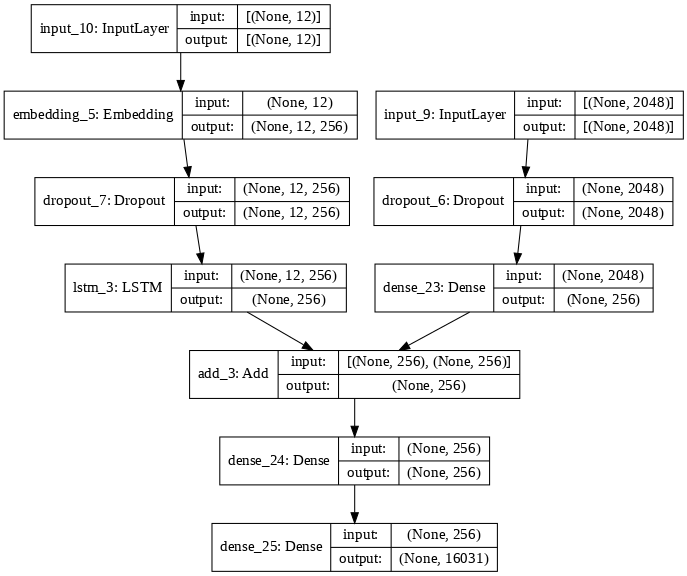

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

### model_FMVL2 (model_baseline_ad)

ref https://github.com/shravannambiar11/Image-captioning-using-Keras

In [ ]:
# model_FMVL2 (model_baseline_ad)
def define_model(vocab_size, max_length):
    embedding_size = 300

    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    x = Dropout(0.5)(se1)
    se2 = LSTM(256)(x)

    # decoder model
    decoder1 = add([fe2, se2])
    #decoder2 = LSTM(256)(decoder1)
    x = Dense(256, activation='relu')(decoder1)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    decoder2 = Dropout(0.5)(x)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_baseline_ad.png', show_shapes=True)
    
    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 300)      746100      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

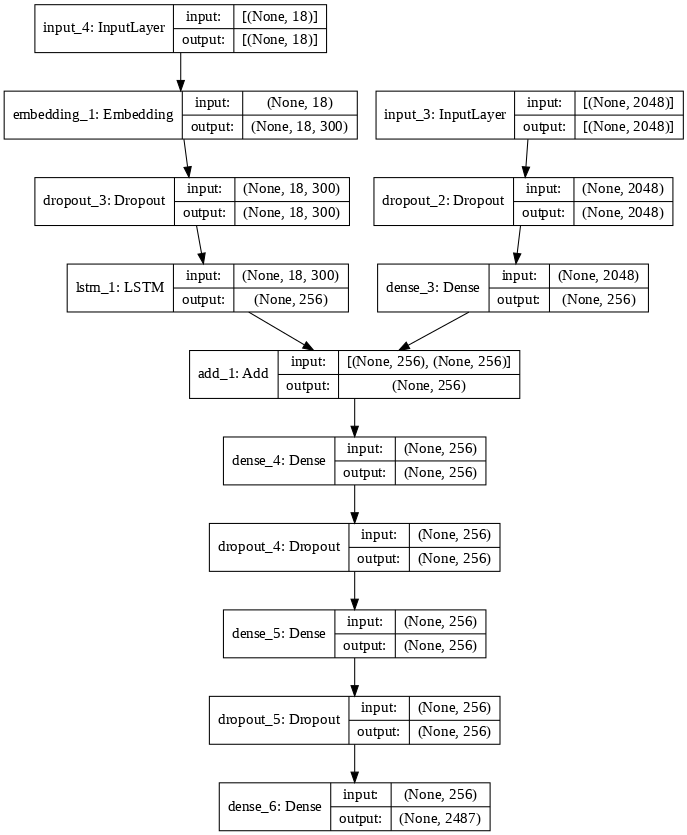

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

In [ ]:
epochs = 11
for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./' + modelname + str(i) + '.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
5538/5538 [==============================] - 298s 54ms/step - loss: 2.5743


### model_FIVL (model_LSTM)

In [ ]:
# model_FIVL (model_LSTM)
def define_model(vocab_size, max_length):
    embedding_size = 300
    add_size = 256

    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(add_size, activation='relu')(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Dense(add_size, activation='relu')(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = LSTM(256)(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_LSTM.png', show_shapes=True)
    
    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 18, 300)      746100      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

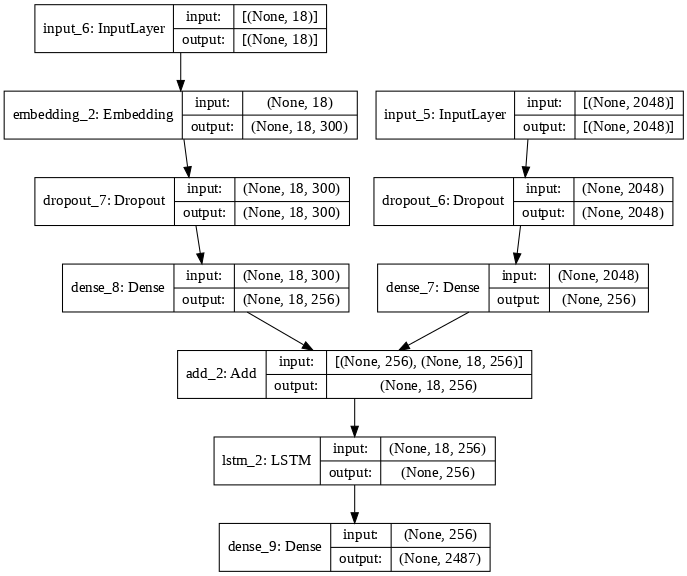

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

In [ ]:
# model_LSTM
epochs = 31
for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./' + modelname + "v2_" + str(i) + '.h5')
    
print("""3/5538 [..............................] - ETA: 4:57 - loss: 5.3266 - perplexity: 241.3200/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
5538/5538 [==============================] - 323s 58ms/step - loss: 2.8512 - perplexity: 196.9675
5538/5538 [==============================] - 325s 59ms/step - loss: 2.1163 - perplexity: 56.4387
5538/5538 [==============================] - 324s 59ms/step - loss: 1.7625 - perplexity: 27.8319
5538/5538 [==============================] - 320s 58ms/step - loss: 1.5320 - perplexity: 19.7988
5538/5538 [==============================] - 324s 58ms/step - loss: 1.3814 - perplexity: 15.9332
5538/5538 [==============================] - 325s 59ms/step - loss: 1.2599 - perplexity: 13.7638
5538/5538 [==============================] - 322s 58ms/step - loss: 1.1811 - perplexity: 11.6505
5538/5538 [==============================] - 325s 59ms/step - loss: 1.1127 - perplexity: 10.2816
5538/5538 [==============================] - 325s 59ms/step - loss: 1.0669 - perplexity: 9.6850
5538/5538 [==============================] - 324s 59ms/step - loss: 1.0218 - perplexity: 9.0229
5538/5538 [==============================] - 325s 59ms/step - loss: 0.9932 - perplexity: 8.6242
5538/5538 [==============================] - 323s 58ms/step - loss: 0.9602 - perplexity: 8.1739
5538/5538 [==============================] - 325s 59ms/step - loss: 0.9415 - perplexity: 7.5994
5538/5538 [==============================] - 329s 59ms/step - loss: 0.9179 - perplexity: 8.0780
5538/5538 [==============================] - 331s 60ms/step - loss: 0.9059 - perplexity: 7.8248
5538/5538 [==============================] - 323s 58ms/step - loss: 0.8900 - perplexity: 7.3889
5538/5538 [==============================] - 318s 57ms/step - loss: 0.8809 - perplexity: 9.0657
5538/5538 [==============================] - 325s 59ms/step - loss: 0.8650 - perplexity: 8.1548
5538/5538 [==============================] - 322s 58ms/step - loss: 0.8616 - perplexity: 8.5846
5538/5538 [==============================] - 320s 58ms/step - loss: 0.8465 - perplexity: 7.3678
5538/5538 [==============================] - 312s 56ms/step - loss: 0.8406 - perplexity: 8.3561
5538/5538 [==============================] - 318s 57ms/step - loss: 0.8360 - perplexity: 8.8021
5538/5538 [==============================] - 320s 58ms/step - loss: 0.8337 - perplexity: 7.2999
5538/5538 [==============================] - 320s 58ms/step - loss: 0.8257 - perplexity: 7.1712
5538/5538 [==============================] - 327s 59ms/step - loss: 0.8158 - perplexity: 6.7660
5538/5538 [==============================] - 326s 59ms/step - loss: 0.8128 - perplexity: 7.5115
5538/5538 [==============================] - 327s 59ms/step - loss: 0.8065 - perplexity: 6.9524
5538/5538 [==============================] - 325s 59ms/step - loss: 0.8055 - perplexity: 7.0926
5538/5538 [==============================] - 324s 58ms/step - loss: 0.8005 - perplexity: 9.4112
5538/5538 [==============================] - 313s 56ms/step - loss: 0.7998 - perplexity: 8.2845
5538/5538 [==============================] - 313s 57ms/step - loss: 0.7937 - perplexity: 8.3293""")

3/5538 [..............................] - ETA: 4:57 - loss: 5.3266 - perplexity: 241.3200/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
5538/5538 [==============================] - 313s 57ms/step - loss: 0.7937 - perplexity: 8.3293


### model_FIVLR (model_LSTM_R)

In [ ]:
# model_FIVLR (model_LSTM_R)
def define_model(vocab_size, max_length):
    embedding_size = 300
    add_size = 256

    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Dense(embedding_size, activation='relu')(se2)
    #x = LSTM(256, return_sequences=True)(x)
    #se2 = TimeDistributed(Dense(300))(x)

    # decoder model
    decoder1 = add([fe3, se3])
    decoder2 = LSTM(256)(decoder1)
    #decoder3 = Dense(256, activation='relu')(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])

    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_LSTM_R.png', show_shapes=True)

    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_9[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 18, 300)      746100      input_10[0][0]                   
____________________________________________________________________________________________

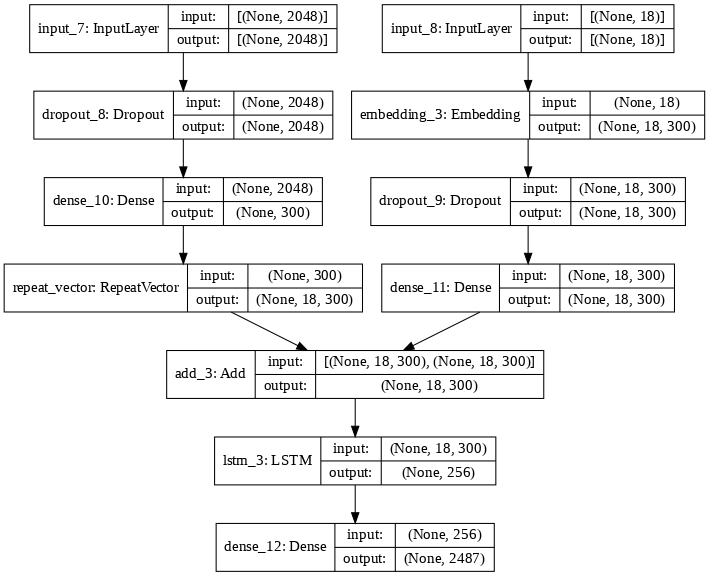

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

In [ ]:
'''
# model_LSTMRT_hand_editv3
epochs = 21
for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./' + modelname + str(i) + '.h5')
'''
print("""/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
5538/5538 [==============================] - 321s 57ms/step - loss: 3.5899 - perplexity: 668.8419
5538/5538 [==============================] - 324s 58ms/step - loss: 2.1043 - perplexity: 59.0120
5538/5538 [==============================] - 319s 58ms/step - loss: 1.6477 - perplexity: 26.5990
5538/5538 [==============================] - 314s 57ms/step - loss: 1.3677 - perplexity: 16.3641
5538/5538 [==============================] - 320s 58ms/step - loss: 1.1714 - perplexity: 11.2327
5538/5538 [==============================] - 319s 58ms/step - loss: 1.0293 - perplexity: 8.6446
5538/5538 [==============================] - 314s 57ms/step - loss: 0.9273 - perplexity: 7.5489
5538/5538 [==============================] - 316s 57ms/step - loss: 0.8486 - perplexity: 6.1604
5538/5538 [==============================] - 318s 57ms/step - loss: 0.7892 - perplexity: 5.7999
5538/5538 [==============================] - 316s 57ms/step - loss: 0.7403 - perplexity: 5.0338
5538/5538 [==============================] - 319s 58ms/step - loss: 0.6937 - perplexity: 4.8132
5538/5538 [==============================] - 318s 57ms/step - loss: 0.6563 - perplexity: 4.3780
5538/5538 [==============================] - 316s 57ms/step - loss: 0.6311 - perplexity: 4.1703
5538/5538 [==============================] - 320s 58ms/step - loss: 0.6139 - perplexity: 4.3955
5538/5538 [==============================] - 319s 58ms/step - loss: 0.5856 - perplexity: 4.2026
5538/5538 [==============================] - 317s 57ms/step - loss: 0.5684 - perplexity: 3.9765
5538/5538 [==============================] - 320s 58ms/step - loss: 0.5522 - perplexity: 3.6506
5538/5538 [==============================] - 314s 57ms/step - loss: 0.5383 - perplexity: 3.5910
5538/5538 [==============================] - 313s 56ms/step - loss: 0.5342 - perplexity: 6.8978
5538/5538 [==============================] - 312s 56ms/step - loss: 0.5173 - perplexity: 3.6675
5538/5538 [==============================] - 312s 56ms/step - loss: 0.5080 - perplexity: 3.4207""")

In [ ]:
# model_LSTM_R
modelname = "model_LSTM_R"
epochs = 21
for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model/' + modelname + '/' + modelname + str(i) + '.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
5538/5538 [==============================] - 338s 61ms/step - loss: 0.8385 - perplexity: 7.2340


### model_FIVLR2 (model_LSTM_R_wd)

In [ ]:
# model_FIVLR2 (model_LSTM_R_wd)
def define_model(vocab_size, max_length):
    embedding_size = 300
    add_size = 256

    # feature extractor model
    inputs1 = Input(shape=(2048,))
    #fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(inputs1)
    fe3 = RepeatVector(max_length)(fe2)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)

    # decoder model
    decoder1 = add([fe3, se1])
    decoder2 = LSTM(256)(decoder1)
    #decoder3 = Dense(256, activation='relu')(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])

    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_LSTM_R_wd.png', show_shapes=True)
    
    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 300)          614700      input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 18, 300)      0           dense_16[0][0]                   
____________________________________________________________________________________________

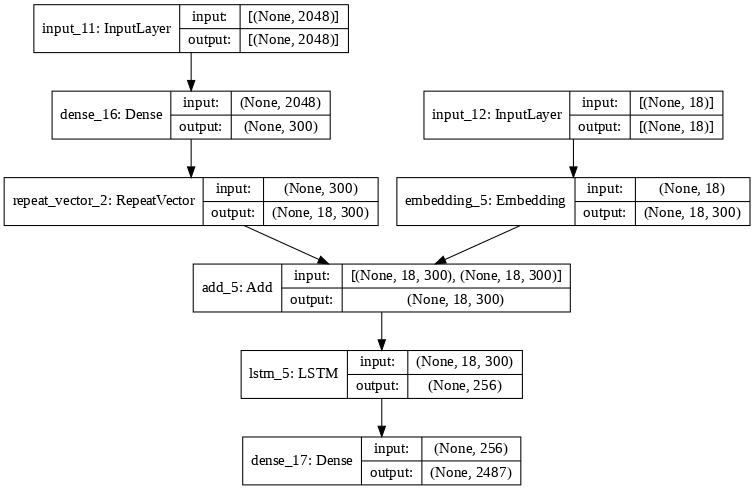

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

### model_FIVLRT (model_LSTM_RT)

In [ ]:
# model_FIVLRT (model_LSTM_RT)
def define_model(vocab_size, max_length):
    embedding_size = 300

    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    x = Dropout(0.5)(se1)
    x = LSTM(256, return_sequences=True)(x)
    se2 = TimeDistributed(Dense(300))(x)

    # decoder model
    decoder1 = add([fe3, se2])
    decoder2 = LSTM(256)(decoder1)
    #decoder3 = Dense(256, activation='relu')(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='./model/model_LSTM_RT.png', show_shapes=True)

    return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 18, 300)      746100      input_14[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 2048)         0           input_13[0][0]                   
____________________________________________________________________________________________

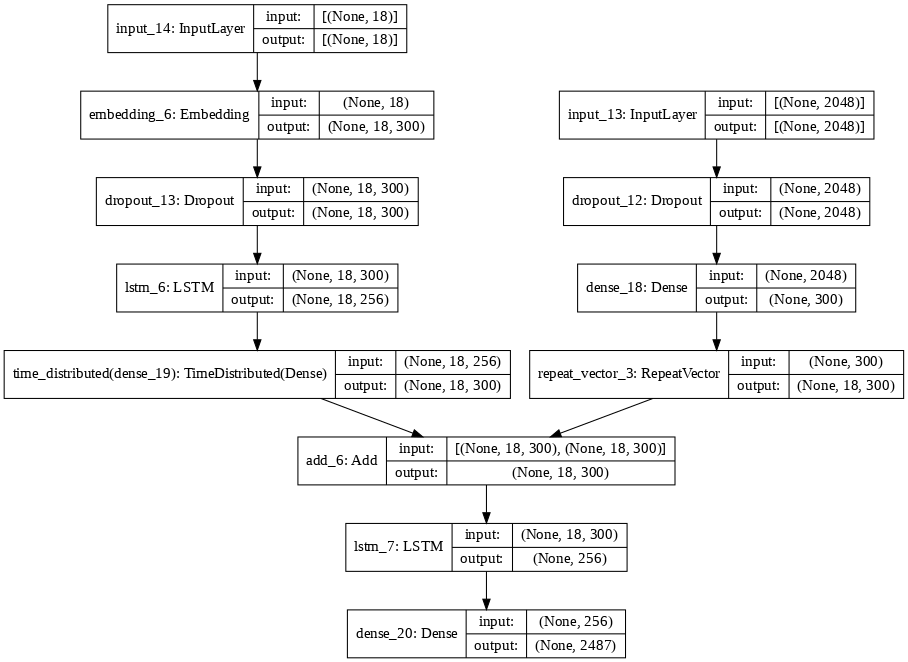

In [ ]:
plot_model(model, show_shapes=True, dpi=75)

## Attention



In [ ]:
from attention_keras.layers.attention import AttentionLayer
# ModuleNotFoundError: No module named 'attention_keras'

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

ModuleNotFoundError: ignored

## Coding model

In [ ]:
epochs = 21
for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model/model_dn_FMVL_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyError: ignored

## Load old model

In [ ]:
dir_model = glob.glob('./model/scrape/model_*')
model_name = []
model_list = []

for dir in dir_model:
    temp = dir.split('/')[-1]
    model_name.append(temp)

    model = load_model(dir,custom_objects={"perplexity": perplexity})
    model_list.append(model)

model_name

['model_baseline_20.h5',
 'model_LSTMRTp_7.h5',
 'model_LSTMRT_5.h5',
 'model_boat_9.h5',
 'model_LSTMRTlp_8.h5',
 'model_BiLSTMRTlp_3.h5',
 'model_baseline_39.h5']

## Load new model

In [ ]:
# load all model
model_name = []
model_list = []
dir_model = glob.glob('./model/model_*')
dir_model.sort()
dir_model = [name.split('/')[-1] for name in dir_model]

for dir in dir_model:
    temp = os.listdir('./model/'+dir)[-1]
    temp = temp.split(".")[0]
    model_name.append(temp)

    model = load_model('./model/'+dir+'/'+ temp +'.h5',custom_objects={"perplexity": perplexity})
    model_list.append(model)

model_name

['model_LSTM_20',
 'model_LSTM_R_20',
 'model_LSTM_RT_20',
 'model_LSTM_RT_seq_10',
 'model_LSTM_RT_seq_AT_10',
 'model_LSTM_R_wd_20',
 'model_baseline_20',
 'model_baseline_ad_10']

In [ ]:
predict_list = []
dir_predict = glob.glob('./predicted/model_*')
for dir in dir_predict:
    temp = glob.glob(dir+'/beam4_predicted500_dict_*')
    temp = [t.split("/")[-1] for t in temp]
    predict_list.append(temp)
    
predict_list

[['beam4_predicted500_dict_model_LSTM_R_wd_10.pkl',
  'beam4_predicted500_dict_model_LSTM_R_wd_20.pkl'],
 ['beam4_predicted500_dict_model_LSTM_R_20.pkl'],
 ['beam4_predicted500_dict_model_LSTM_20.pkl',
  'beam4_predicted500_dict_model_LSTM_5.pkl'],
 ['beam4_predicted500_dict_model_LSTM_RT_20.pkl'],
 ['beam4_predicted500_dict_model_baseline_ad_10.pkl'],
 ['beam4_predicted500_dict_model_baseline_20.pkl']]

## Load model

In [ ]:
'''model_baseline_20 = load_model('./model/model_baseline_20.h5')
model_LSTMRT_5 = load_model('./model/model_LSTMRT_5.h5')
model_LSTMRTp_7 = load_model('./model/model_LSTMRTp_7.h5',custom_objects={"perplexity": perplexity})
model_boat_9 = load_model('./model/model_boat_9.h5',custom_objects={"perplexity": perplexity})
model_baseline_39 = load_model('./model/model_baseline_39.h5')
model_LSTMRTlp_8 = load_model('./model/model_LSTMRTlp_8.h5',custom_objects={"perplexity": perplexity})
model_BiLSTMRTlp_3 = load_model('./model/model_BiLSTMRTlp_3.h5',custom_objects={"perplexity": perplexity})
'''

In [ ]:
model_LSTM_RT_seq = load_model('./model/model_LSTM_RT_seq/model_LSTM_RT_seq_10.h5',custom_objects={"perplexity": perplexity})
model_LSTM_RT_seq_AT = load_model('./model/model_LSTM_RT_seq_AT/model_LSTM_RT_seq_AT_10.h5',custom_objects={"perplexity": perplexity})

In [ ]:
model_LSTM_RT_seq_AT = load_model('./model/model_LSTM_RT_seq_AT/model_LSTM_RT_seq_AT_20.h5',custom_objects={"perplexity": perplexity})

In [ ]:
beam_index = 4
model_list = [model_LSTM_RT_seq_AT]
model_name = ["model_LSTM_RT_seq_AT_20"]

In [ ]:
# Predict val 500
beam_index = 4
model_list = [model_LSTM_RT_seq, model_LSTM_RT_seq_AT]
model_name = ["model_LSTM_RT_seq_10", "model_LSTM_RT_seq_AT_10"]

In [ ]:
dir_model = ["model_LSTM_RT_seq_AT"]

In [ ]:
beam_index = 4

# 5. Prediction

## Define Function Predict

In [ ]:
# predict คำอธิบายออกมาในรูปแบบ list ที่ถูก split แล้ว และมีรูปแบบ dict ที่เก็บไว้เป็นประโยคของคำอธิบายอีกด้วย 
# โดยสามารถเลือกได้ว่าจะใช้ generate_desc เป็น argmax_search หรือ beam_search 
def predict_all_desc_dict(model, descriptions, photos, tokenizer, max_length, generate_desc):
    actual, predicted = list(), list()
    predicted_dict = dict()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list[0]]       #editz
        actual.append(actual_desc)
        predicted.append(prediction.split())
        predicted_dict[key] = prediction          # เก็บในรูปแบบ dict ด้วย
    return actual, predicted, predicted_dict

In [ ]:
def argmax_search(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]     # เปลี่ยนจาก text เป็น sequences(ชุดตัวเลข)
        sequence = pad_sequences([sequence], maxlen=max_length)   # padding ในที่นี้คือ การเติม 0 ให้ input มีขนาดเท่ากัน เท่ากับ max_len
        prob = model.predict([photo,sequence], verbose=0)         # ทำนายคำ จากรูปภาพและseqก่อนหน้า
        prob = np.argmax(prob)                                       # แปลงจากความน่าจะเป็น เป็น ตัวเลขจำนวนเต็ม
        word = word_for_id(prob, tokenizer)                       # map ตัวเลข กับ คำศัพท์
        if word is None:
            break
        in_text += word
        #in_text += ' ' + word                                     # นำคำที่ถูกทำนายมาต่อท้าย
        if word == '<end>':
            break
    return in_text      

In [ ]:
def beam_search(model, tokenizer, photo, max_length):
    in_text = '<start>'
    start = tokenizer.texts_to_sequences([in_text])[0]
    start_word = [[start, 0.0]]                       # start_word[0][0] = index of the starting word
                                                      # start_word[0][1] = probability of the word predicted
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length)   # padding ในที่นี้คือ การเติม 0 ให้ input มีขนาดเท่ากัน เท่ากับ max_len
            preds = model.predict([photo,sequence], verbose=0)    # ทำนายคำ จากรูปภาพและseqก่อนหน้า　　　#([np.array([e]), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]       # ทำนายออกมา top n beam_index
            for w in word_preds:                                  # สร้าง list ขึ้นมาใหม่
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])                     # เก็บ คำศัพท์ที่ทำนายได้ พร้อมกับความน่าจะเป็น
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])   # เรียงคำศัพท์ ตามความน่าจะเป็น
        start_word = start_word[-beam_index:]                                # เอาคำศัพท์ออกมา top n beam ออกมา
    
    start_word = start_word[-1][0]
    intermediate_caption = [word_for_id(prob, tokenizer) for prob in start_word]
    final_caption = []
    for w in intermediate_caption:
        if w != '<end>':
            final_caption.append(w)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# ฟังก์ชั่นที่ไว้ map ตัวเลข กลับไปเป็น คำศัพท์
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():   
        if index == integer:
            return word
    return None

## Define Function Convert

In [ ]:
def convert_dictList_to_dictSentence(dictionary,row=1000000,split=""):
    count = 1
    new_dict = dict()
    for key,value in dictionary.items():
        if count < row:
            new_dict[key] = split.join(value[1:-1])
        count += 1
    return new_dict

In [ ]:
def convert_dictList_to_dictSentence_list(dictionary,row=1000000,split=""):
    count = 1
    new_dict = dict()
    for key,value in dictionary.items():
        if count < row:
            new_dict[key] = list()
            for v in value:
                new_dict[key].append(split.join(v[1:-1]))
        count += 1
    return new_dict

In [ ]:
def show_dict(dictionary,row=1000000):
    for key in list(dictionary.keys())[:row]:
        print(dictionary[key])

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename, t_replace=" "):
    lines = list()
    for key, value in descriptions.items():
        lines.append(value.replace(t_replace,""))
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
import keras
def perplexity(y_true, y_pred):
    cross_entropy = keras.backend.categorical_crossentropy(y_true, y_pred)
    perplexity = keras.backend.pow(2.0, cross_entropy)
    return perplexity

In [ ]:
def split_train_test(dictionary,row):
    temp_list = list(dictionary.items())
    random.shuffle(temp_list)
    new_train_dict = dict(temp_list[:row])
    new_test_dict = dict(temp_list[row:])
    print("Train :",len(new_train_dict))
    print("Test :",len(new_test_dict))
    return new_train_dict,new_test_dict

## Coding Predict val500

In [ ]:
val_dict = load(open("./pickle"+folder+"/val_dict.pkl", "rb"))

In [ ]:
show_dict(val_dict,10)

[['<start>', 'เสื้อเชิ้ต', 'แขน', 'สั้น', 'ผ้า', 'ส', 'ปัน', 'พิม', 'ลาย', 'รุ้ง', 'เนื้อผ้า', 'ใส่', 'สบาย', 'สุด', 'ๆแมช', 'ง่าย', 'มาก', 'คะ', 'มา', 'พร้อม', 'ผ้าโพกหัว', 'ลาย', 'เข้า', 'เซ', 'ท', 'ใส่', 'เที่ยว', 'รับ', 'ซัมเมอร์', 'นี้', 'ได้', 'เลย', 'คะ', '<end>']]
[['<start>', 'แม่ค้า', 'ขออนุญาต', 'เพิ่ม', 'ระยะเวลา', 'ใน', 'การจัดส่ง', 'สินค้า', 'เป็น', 'วัน', 'นะคะ', 'เพื่อ', 'ที่ทาง', 'แม่ค้า', 'ได้', 'จัดหา', 'สินค้า', 'ให้ได้', 'ตาม', 'ต้องการ', 'และ', 'ตรงเวลา', 'ค่ะ', 'หาก', 'สินค้า', 'ได้', 'สินค้า', 'มา', 'ก่อ', 'น', 'กำหนด', 'โดยประมาณ', 'อาทิตย์', 'ทาง', 'ร้าน', 'ก็', 'จัดส่ง', 'ให้', 'เลย', 'ค่ะ', 'เพื่อ', 'ป้องกัน', 'การ', 'ถูก', 'ระงับ', 'หน้า', 'เวป', 'ค่ะ', '<end>']]
[['<start>', 'แบตเตอรี่', 'สำรอง', 'อึด', 'ทน', 'ชาร์จ', 'ได้', 'นาน', 'มี', 'ไฟ', 'สี', 'ฟ้า', 'แสดง', 'สถานะ', 'ปริมาณ', 'แบตเตอรี่', 'ขนาด', 'ความจุ', 'จริง', 'ความจุ', 'ที่', 'สกรีน', 'จาก', 'โรงงาน', 'มี', 'ช่อง', 'ขนาดที่', 'บาง', 'เฉียบ', 'และ', 'สี', 'ฟ้า', 'สด', 'สวยงาม', 'ชา', 'คร์', 'ได้

In [ ]:
convert_dictList_to_dictSentence_list(val_dict,10,"")

{'L90662291.jpg': [''],
 'L90672977.jpg': ['แบตเตอรี่สำรองอึดทนชาร์จได้นานมีไฟสีฟ้าแสดงสถานะปริมาณแบตเตอรี่ขนาดความจุจริงความจุที่สกรีนจากโรงงานมีช่องขนาดที่บางเฉียบและสีฟ้าสดสวยงามชาคร์ได้รอบลองทดลองชาคร์กับมีบอกสถานะแบตสีเหลืองดวงเมื่อไฟแบตเตอรี่เหลือและ'],
 'L91225404.jpg': ['แม่ค้าขออนุญาตเพิ่มระยะเวลาในการจัดส่งสินค้าเป็นวันนะคะเพื่อที่ทางแม่ค้าได้จัดหาสินค้าให้ได้ตามต้องการและตรงเวลาค่ะหากสินค้าได้สินค้ามาก่อนกำหนดโดยประมาณอาทิตย์ทางร้านก็จัดส่งให้เลยค่ะเพื่อป้องกันการถูกระงับหน้าเวปค่ะ'],
 'L91248125.jpg': [''],
 'L91251272.jpg': [''],
 'L91450280.jpg': ['สบู่ลูกพีชลดสิวหน้ากระจ่างใสรวมสารสกัดจากพีชเกาหลีวิตามินวิตามินและกลูต้าช่วยปรับผิวให้ขาวกระจ่างใสภายในวันช่วยลดปัญหาสิวฝ้ากระจุดด่างดำได้อย่างดีเยี่ยมอีกด้วยผิวกระจ่างใสอมชมพูลดริ้วรอยจุดด่างดำลดสิวป้องกันการเกิดสิวทำความสะอาดผิวหน้าได้หมดจดคนที่มีผิวแพ้ง่ายก็สามารถใช้ได้เลขที่จดแจ้งขนาดกรัม'],
 'L91519080.jpg': ['เสื้อเชิ้ตแขนสั้นผ้าสปันพิมลายรุ้งเนื้อผ้าใส่สบายสุดๆแมชง่ายมากคะมาพร้อมผ้าโพกหัวลายเข้าเซทใส่เที่ยวรับซัมเมอร์นี

## Predict 
save pkl & txt

In [ ]:
dir_model = [m.split(".")[0] for m in model_name]

In [ ]:
# Predict argmax_search
for dir,model,name in zip(dir_model,model_list,model_name):
    start = time.time()
    actual, predicted, predicted_dict = predict_all_desc_dict(model, val_dict, train_features, tokenizer, max_length, argmax_search)     # เลือกระหว่าง argmax_search กับ beam_search
    end = time.time()
    print(name+" \tTake time :",(end-start)/60,"mins")

    try:  
        os.mkdir("./predicted/old_model/"+dir)  
    except OSError as error:  
        print(error)   

    # save pkl
    dump(predicted, open("./predicted/old_model/"+dir+"/argmax_predicted500_"+name+".pkl", "wb"))
    dump(predicted_dict, open("./predicted/old_model/"+dir+"/argmax_predicted500_dict_"+name+".pkl", "wb"))

    # save txt
    temp_p_dict = convert_dictList_to_dictSentence(predicted_dict)
    save_descriptions(temp_p_dict, "./predicted/old_model/"+dir+"/argmax_predicted500_text_"+name+".txt","")
#dump(actual, open("./predicted/actual500.pkl", "wb"))

model_baseline_20.h5 	Take time : 7.473801231384277 mins
model_LSTMRTp_7.h5 	Take time : 8.281886390844981 mins
model_LSTMRT_5.h5 	Take time : 8.288137769699096 mins
model_boat_9.h5 	Take time : 8.206052581469217 mins
model_LSTMRTlp_8.h5 	Take time : 8.245035135746003 mins
model_BiLSTMRTlp_3.h5 	Take time : 11.125914827982585 mins
model_baseline_39.h5 	Take time : 7.33877747853597 mins


In [ ]:
# Predict beam_search
for dir,model,name in zip(dir_model,model_list,model_name):
    start = time.time()
    actual, predicted, predicted_dict = predict_all_desc_dict(model, val_dict, train_features, tokenizer, max_length, beam_search)     # เลือกระหว่าง argmax_search กับ beam_search
    end = time.time()
    print(name+" \tTake time :",(end-start)/60,"mins")

    try:  
        os.mkdir("./predicted/old_model/"+dir)  
    except OSError as error:  
        print(error)   

    # save pkl
    dump(predicted, open("./predicted/old_model/"+dir+"/beam4_predicted500_"+name+".pkl", "wb"))
    dump(predicted_dict, open("./predicted/old_model/"+dir+"/beam4_predicted500_dict_"+name+".pkl", "wb"))

    # save txt
    temp_p_dict = convert_dictList_to_dictSentence(predicted_dict)
    save_descriptions(temp_p_dict, "./predicted/old_model/"+dir+"/beam4_predicted500_text_"+name+".txt","")
#dump(actual, open("./predicted/actual500.pkl", "wb"))

model_baseline_20.h5 	Take time : 27.96945899327596 mins
[Errno 17] File exists: './predicted/old_model/model_baseline_20'
model_LSTMRTp_7.h5 	Take time : 30.715145564079286 mins
[Errno 17] File exists: './predicted/old_model/model_LSTMRTp_7'
model_LSTMRT_5.h5 	Take time : 30.738284929593405 mins
[Errno 17] File exists: './predicted/old_model/model_LSTMRT_5'
model_boat_9.h5 	Take time : 28.818333331743876 mins
[Errno 17] File exists: './predicted/old_model/model_boat_9'
model_LSTMRTlp_8.h5 	Take time : 30.641392242908477 mins
[Errno 17] File exists: './predicted/old_model/model_LSTMRTlp_8'


In [ ]:
print("""model_baseline_ad_10 	Take time : 5.422754009564717 mins
model_LSTM_R_20 	Take time : 5.69978195031484 mins

model_LSTMRT_hand_editv3_10 	Take time : 5.488074803352356 mins
model_LSTMRT_hand_editv3_20 	Take time : 5.476129178206126 mins
model_LSTMRT_hand_editv3_20 	Take time : 5.499476067225138 mins
model_LSTMRT_hand_edit_v2_5 	Take time : 5.472812080383301 mins
model_LSTM_RT_seq_10 	Take time : 5.204427440961202 mins
model_LSTM_RT_seq_AT_10 	Take time : 5.2558798551559445 mins

model_LSTMRT_hand_20 	Take time : 7.895065097014109 mins
model_baseline_hand_20 	Take time : 11.409136899312337 mins
model_baseline_39 	Take time : 7.750887628396352 mins
model_LSTMRTlp_8 	Take time : 8.579770815372466 mins
model_BiLSTMRTlp_3 	Take time : 12.109133835633596 mins
model_baseline_15 	Take time : 7.4178541938463844 mins
model_baseline_20 	Take time : 7.361677626768748 mins
model_LSTMRT_5 	Take time : 9.610268354415894 mins
model_boat_9 	Take time : 8.586819891134898 mins
model_LSTMRTp_7 	Take time : 9.709063641230266 mins
""")

In [ ]:
'''for model,name in zip(model_list,model_name):
    predicted_dict = load(open("./pickle/predicted/beam4_predicted500_dict_"+name+".pkl", "rb"))
    temp_p_dict = convert_dictList_to_dictSentence(predicted_dict)
    save_descriptions(temp_p_dict, "./pickle/predicted/predicted500_text_"+name+".txt","")
'''

In [ ]:
# Predict beam_search
for dir,model,name in zip(dir_model,model_list,model_name):
    start = time.time()
    actual, predicted, predicted_dict = predict_all_desc_dict(model, val_dict, train_features, tokenizer, max_length, beam_search)     # เลือกระหว่าง argmax_search กับ beam_search
    end = time.time()
    print(name+" \tTake time :",(end-start)/60,"mins")
    
    # save pkl
    dump(predicted, open("./predicted/"+dir+"/beam4_predicted500_"+name+".pkl", "wb"))
    dump(predicted_dict, open("./predicted/"+dir+"/beam4_predicted500_dict_"+name+".pkl", "wb"))

    # save txt
    temp_p_dict = convert_dictList_to_dictSentence(predicted_dict)
    save_descriptions(temp_p_dict, "./predicted/"+dir+"/beam4_predicted500_text_"+name+".txt","")
#dump(actual, open("./predicted/actual500.pkl", "wb"))



model_LSTM_RT_seq_AT_20 	Take time : 18.30734020471573 mins


In [ ]:
# beam_search
print("""model_baseline_ad_10 	Take time : 19.476808067162832 mins
model_LSTM_R_20 	Take time : 20.257573024431863 mins

model_LSTMRT_hand_editv3_10 	Take time : 19.75598305463791 mins
model_LSTMRT_hand_editv3_20 	Take time : 19.489210736751556 mins
model_LSTMRT_hand_editv3_20 	Take time : 20.025142749150593 mins
model_LSTMRT_hand_edit_v2_5 	Take time : 19.849027637640635 mins
model_LSTM_RT_seq_10 	Take time : 18.94760683377584 mins
model_LSTM_RT_seq_AT_10 	Take time : 18.807268726825715 mins

model_LSTMRT_hand_20 	Take time : 28.240158847967784 mins
model_baseline_hand_20 	Take time : 43.2687041759491 mins
model_baseline_20 	Take time : 30.951670277118684 mins
model_LSTMRT_5 	Take time : 35.82209946314494 mins
model_LSTMRTp_7 	Take time : 34.271506416797635 mins
model_boat_9 	Take time : 31.883224618434905 mins""")

# 6. Evaluate the model
ความหมายพวก BLEU https://medium.com/explorations-in-language-and-learning/metrics-for-nlg-evaluation-c89b6a781054

## 6.1 nlg-eval
https://github.com/Maluuba/nlg-eval

In [ ]:
# Install the Python dependencies.
!pip install git+https://github.com/Maluuba/nlg-eval.git@master

# Simple setup:
# Download required data (e.g. models, embeddings) and external code files.
!nlg-eval --setup

  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-req-build-fbmte8ml
  Running command git clone -q https://github.com/Maluuba/nlg-eval.git /tmp/pip-req-build-fbmte8ml
  Created wheel for nlg-eval: filename=nlg_eval-2.3-cp36-none-any.whl size=68175138 sha256=1acfc9b4f04d2e13ee607b912e21d205cf8705e33682814cb71a921201ea108d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzk72kdz/wheels/a5/7c/fd/f312beca2adcc3f49cb40570730658dad37bb5709f5d237a56
Successfully built nlg-eval
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing to /root/.cache/nlgeval
In case of incomplete downloads, delete the directory and run `nlg-eval --setup /root/.cache/nlgeval' again.
glove2word2vec.py: 100% 1.00/1.00 [00:00<00:00, 537 chunks/s]
dictionary.txt: 550 chunks [00:00, 794 chunks/s]
uni_skip.npz: 100% 634/634 [00:16<00:00, 38.9 chunks/s]
uni_skip.npz.pkl: 100% 1.00/1.00 [00:00<00:00, 1.27k chunks/s]
bi_skip.n

In [ ]:
# compute_metrics
from nlgeval import compute_metrics
metrics_dict = dict()
for name in model_name:
    metrics_dict[name] = compute_metrics(hypothesis='./pickle/predicted/argmax_predicted500_text_'+name+'.txt',
                                         references=['val_dict_.txt'])
    dump(metrics_dict, open("./pickle/metrics_dict/argmax_metrics_"+name+".pkl", "wb"))

Bleu_1: 0.000000
Bleu_2: 0.000000
Bleu_3: 0.000000
Bleu_4: 0.000000
METEOR: 0.056591
ROUGE_L: 0.000000
CIDEr: 0.000000


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


SkipThoughtsCosineSimilarity: 0.372736
EmbeddingAverageCosineSimilarity: -0.076542
EmbeddingAverageCosineSimilairty: -0.076542
VectorExtremaCosineSimilarity: -0.268953
GreedyMatchingScore: 0.584074
Bleu_1: 0.000000
Bleu_2: 0.000000
Bleu_3: 0.000000
Bleu_4: 0.000000
METEOR: 0.033117
ROUGE_L: 0.000000
CIDEr: 0.000000
SkipThoughtsCosineSimilarity: 0.372736
EmbeddingAverageCosineSimilarity: -0.076542
EmbeddingAverageCosineSimilairty: -0.076542
VectorExtremaCosineSimilarity: -0.268953
GreedyMatchingScore: 0.584074
Bleu_1: 0.000000
Bleu_2: 0.000000
Bleu_3: 0.000000
Bleu_4: 0.000000
METEOR: 0.070625
ROUGE_L: 0.000000
CIDEr: 0.000000
SkipThoughtsCosineSimilarity: 0.372736
EmbeddingAverageCosineSimilarity: -0.076542
EmbeddingAverageCosineSimilairty: -0.076542
VectorExtremaCosineSimilarity: -0.268953
GreedyMatchingScore: 0.584074


In [ ]:
for name in model_name: 
    print(name, end="")
    print(metrics_dict[name])

model_baseline_39{'Bleu_1': 2.484607942249858e-47, 'Bleu_2': 1.7568831245565852e-41, 'Bleu_3': 1.5652049235903796e-39, 'Bleu_4': 1.4773567214601163e-38, 'METEOR': 0.05659074703947296, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SkipThoughtCS': 0.3727357, 'EmbeddingAverageCosineSimilarity': -0.076542, 'EmbeddingAverageCosineSimilairty': -0.076542, 'VectorExtremaCosineSimilarity': -0.268953, 'GreedyMatchingScore': 0.584074}
model_LSTMRTlp_8{'Bleu_1': 2.484607942249858e-47, 'Bleu_2': 1.7568831245565852e-41, 'Bleu_3': 1.5652049235903796e-39, 'Bleu_4': 1.4773567214601163e-38, 'METEOR': 0.033117016895135895, 'ROUGE_L': 0.0, 'CIDEr': 0.0, 'SkipThoughtCS': 0.3727357, 'EmbeddingAverageCosineSimilarity': -0.076542, 'EmbeddingAverageCosineSimilairty': -0.076542, 'VectorExtremaCosineSimilarity': -0.268953, 'GreedyMatchingScore': 0.584074}
model_BiLSTMRTlp_3{'Bleu_1': 2.484607942249858e-47, 'Bleu_2': 1.7568831245565852e-41, 'Bleu_3': 1.5652049235903796e-39, 'Bleu_4': 1.4773567214601163e-38, 'METEOR': 0.07062545

In [ ]:
metrics_dict[model_name[0]]

{'Bleu_1': 2.484607942249858e-47,
 'Bleu_2': 1.7568831245565852e-41,
 'Bleu_3': 1.5652049235903796e-39,
 'Bleu_4': 1.4773567214601163e-38,
 'CIDEr': 0.0,
 'EmbeddingAverageCosineSimilairty': -0.076542,
 'EmbeddingAverageCosineSimilarity': -0.076542,
 'GreedyMatchingScore': 0.584074,
 'METEOR': 0.05659074703947296,
 'ROUGE_L': 0.0,
 'SkipThoughtCS': 0.3727357,
 'VectorExtremaCosineSimilarity': -0.268953}

In [ ]:
metrics_dict[model_name[1]]

{'Bleu_1': 2.484607942249858e-47,
 'Bleu_2': 1.7568831245565852e-41,
 'Bleu_3': 1.5652049235903796e-39,
 'Bleu_4': 1.4773567214601163e-38,
 'CIDEr': 0.0,
 'EmbeddingAverageCosineSimilairty': -0.076542,
 'EmbeddingAverageCosineSimilarity': -0.076542,
 'GreedyMatchingScore': 0.584074,
 'METEOR': 0.033117016895135895,
 'ROUGE_L': 0.0,
 'SkipThoughtCS': 0.3727357,
 'VectorExtremaCosineSimilarity': -0.268953}

In [ ]:
metrics_dict[model_name[2]]

{'Bleu_1': 2.484607942249858e-47,
 'Bleu_2': 1.7568831245565852e-41,
 'Bleu_3': 1.5652049235903796e-39,
 'Bleu_4': 1.4773567214601163e-38,
 'CIDEr': 0.0,
 'EmbeddingAverageCosineSimilairty': -0.076542,
 'EmbeddingAverageCosineSimilarity': -0.076542,
 'GreedyMatchingScore': 0.584074,
 'METEOR': 0.0706254563770373,
 'ROUGE_L': 0.0,
 'SkipThoughtCS': 0.3727357,
 'VectorExtremaCosineSimilarity': -0.268953}

In [ ]:
# individual_metrics
'''
from nlgeval import compute_individual_metrics
metrics_dict = compute_individual_metrics([new_dict['L91607581.jpg']],predicted['L91607581.jpg'])
metrics_dict
'''

{'Bleu_1': 4.347826086767486e-17,
 'Bleu_2': 4.445542244546194e-17,
 'Bleu_3': 4.548589342479408e-17,
 'Bleu_4': 4.657469806953482e-17,
 'CIDEr': 0.0,
 'EmbeddingAverageCosineSimilairty': 1.0,
 'EmbeddingAverageCosineSimilarity': 1.0,
 'GreedyMatchingScore': 1.0,
 'METEOR': 0.22088208576394666,
 'ROUGE_L': 0.0,
 'SkipThoughtCS': 0.43707,
 'VectorExtremaCosineSimilarity': 1.0}

## 6.2 nltk.translate
https://www.nltk.org/api/nltk.translate.html

In [ ]:
import nltk.translate
#print(dir(nltk.translate))          # แสดง sub library เพื่อหา matrix นอกจาก bleu_score

In [ ]:
# โหลด matrix มาใช้ โดยส่วนใหญ่แล้ว หาชื่อมาจากเว็บไซต์ https://www.nltk.org/api/nltk.translate.html
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.ribes_score import corpus_ribes
from nltk.translate.chrf_score import corpus_chrf
from nltk.translate.gleu_score import corpus_gleu
#from nltk.translate.meteor_score import corpus_meteor      # meteor ที่อยากใช้แต่ import ไม่ได้
from nltk.translate.nist_score import corpus_nist

In [ ]:
def evalute_nltk(actual, predicted):
    print('BLEU-1 :', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2 :', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3 :', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4 :', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    #print('RIBES :', corpus_ribes(actual, predicted))
    #print('CHRF :', corpus_chrf(actual, predicted))
    #print('GLEU :', corpus_gleu(actual, predicted))
    #print('NIST :', corpus_nist(actual, predicted))
# ที่ถูก # เพราะยังไม่สามารถใช้งานได้ อาจเป็นเพราะรูปแบบ input ไม่ตรงตาม doc ของแต่ละฟังก์ชั่น ซึ่งไม่มีเวลาในการแก้บัค

In [ ]:
temp_m = [m.split("_")[:-1] for m in model_name]
folder_model = ["_".join(m) for m in temp_m]
folder_model

['model_LSTM_RT_seq_AT']

In [ ]:
model_name

['model_LSTM_RT_seq_AT_20']

In [ ]:
actual  = load(open("./predicted/actual500.pkl", "rb"))

In [ ]:
# beam_search
#actual = load(open("./pickle/predicted/actual500.pkl", "rb"))
for model,name,fol in zip(model_list,model_name,folder_model):
    print(name)
    predicted = load(open("./predicted/"+fol+"/beam4_predicted500_"+name+".pkl", "rb"))
    evalute_nltk(actual,predicted)
    print("\n")

model_LSTM_RT_seq_AT_20


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1 : 0.08894117647058825
BLEU-2 : 0.2982300730486251
BLEU-3 : 0.4838724113698667
BLEU-4 : 0.5461044525075995




In [ ]:
# argmax
#actual = load(open("./pickle/predicted/actual500.pkl", "rb"))
for model,name,fol in zip(model_list,model_name,folder_model):
    print(name)
    predicted = load(open("./predicted/"+fol+"/argmax_predicted500_"+name+".pkl", "rb"))
    evalute_nltk(actual,predicted)
    print("\n")

model_LSTM_RT_seq_10
BLEU-1 : 0
BLEU-2 : 0
BLEU-3 : 0
BLEU-4 : 0


model_LSTM_RT_seq_AT_10
BLEU-1 : 0
BLEU-2 : 0
BLEU-3 : 0
BLEU-4 : 0




In [ ]:
# beam old
print("""
model_LSTMRT_hand_20
BLEU-1 : 0.01941176470588235
BLEU-2 : 0.1393261092038472
BLEU-3 : 0.3064922557723052
BLEU-4 : 0.373264127936033
GLEU : 0.0036129032258064514
NIST : 0.0

model_baseline_hand_20
BLEU-1 : 0.04215384615384616
BLEU-2 : 0.20531401840557834
BLEU-3 : 0.38676855852035097
BLEU-4 : 0.45311589952856246
GLEU : 0.005612244897959183
NIST : 0.0

model_baseline_20
BLEU-1 : 0.011739130434782604
BLEU-2 : 0.10834726777719227
BLEU-3 : 0.2635668453120799
BLEU-4 : 0.329161461561332
GLEU : 0.0026511627906976743
NIST : 0.0

model_LSTMRT_5
BLEU-1 : 0.05034782608695651
BLEU-2 : 0.2243832125782954
BLEU-3 : 0.40793805134960487
BLEU-4 : 0.4736910518241773
GLEU : 0.006604651162790698
NIST : 0.0

model_LSTMRTp_7
BLEU-1 : 0.022260869565217396
BLEU-2 : 0.14920076931845022
BLEU-3 : 0.31934685058998297
BLEU-4 : 0.386265154160261
GLEU : 0.004558139534883721
NIST : 0.0

model_boat_9
BLEU-1 : 0.0012173913043478258
BLEU-2 : 0.03489113503954587
BLEU-3 : 0.13354543854481443
BLEU-4 : 0.18679168889312467
GLEU : 0.00030232558139534885
NIST : 0.0""")

In [ ]:
# arg old
print("""model_baseline_15
BLEU-1 : 0.09136
BLEU-2 : 0.302258167797001
BLEU-3 : 0.48778318742274046
BLEU-4 : 0.5497801085861519
GLEU : 0.010638297872340425
NIST : 0.0

model_baseline_20
BLEU-1 : 0.09424
BLEU-2 : 0.3069853416695983
BLEU-3 : 0.49234619196549073
BLEU-4 : 0.5540625791998575
GLEU : 0.010638297872340425
NIST : 0.0

model_LSTMRTp_7
BLEU-1 : 0.046079999999999996
BLEU-2 : 0.2146625258399798
BLEU-3 : 0.39724070238792714
BLEU-4 : 0.4633168741153076
GLEU : 0.010638297872340425
NIST : 0.0

model_boat_9
BLEU-1 : 0.04071999999999999
BLEU-2 : 0.201791972090071
BLEU-3 : 0.3827739120665817
BLEU-4 : 0.4492126134583389
GLEU : 0.010638297872340425
NIST : 0.0""")

## 6.2 pycocoevalcap
เป็นอีก library นึงที่มี matrix ในการวัดผล
และที่สำคัญ เป็น library ที่ถูกสร้างขึ้นเพื่อ Evalutate dataset coco โดยเฉพาะ

https://github.com/cocodataset/cocoapi <br>
คล้ายๆกัน https://github.com/tylin/coco-caption <br>
คล้ายๆกัน https://github.com/wangleihitcs/CaptionMetrics

In [ ]:
!pip -q install "git+https://github.com/salaniz/pycocoevalcap.git"
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-qccjs3vx
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-qccjs3vx
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-cp36-none-any.whl size=104312216 sha256=3f9d4819fadcae0e412d82dbd87ac7ca0fbb6e33518d8a8645b2a75f5d1a142d
  Stored in directory: /tmp/pip-ephem-wheel-cache-znvtkzr0/wheels/43/c5/1e/8c540096ae74b7789563f1ba2a0e195308ee86f445a0cda110
Successfully built pycocoevalcap


In [ ]:
def score(ref, sample):
    # ref and sample are both dict
    scorers = [
        #(Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        print('computing %s score with COCO-EVAL...'%(scorer.method()))
        score, scores = scorer.compute_score(ref, sample)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores
    
# ดูเป็นโค้ดที่น่าใช้งานได้เลย แต่พอนำมาใช้จริง กลับเจอ error ที่แก้ข้างค่อนยาก
# ทำให้ไม่ประสบความสำเร็จในการนำ matrix อื่น มาช่วยประเมินผลของโมเดล

In [ ]:
gts

In [ ]:
res

In [ ]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
print('tokenization...')
tokenizer = PTBTokenizer()
gts  = tokenizer.tokenize(predicted_dict)
res = tokenizer.tokenize(predicted_dict)

tokenization...


TypeError: ignored

In [ ]:
score(new_val_dict,new_val_dict)

# 7. Generate new descriptions with picture

In [ ]:
all_predicted_dict = {}
for dir,model,name in zip(dir_model,model_list,model_name):
    predicted_dict = load(open("./predicted/"+dir+"/argmax_predicted500_dict_"+name+".pkl", "rb"))
    all_predicted_dict[name] = predicted_dict
    print(name,"\t",[predicted_dict[k] for k in predicted_dict.keys()][0])

model_LSTM_RT_seq_AT_20 	 <start>สีขาวสีสีสีสีสีสีสีสีสีสีสีสีสีสีสีสี


In [ ]:
dir_predict_dict = []
for dir in dir_model:
    dir_predict_dict.append(glob.glob("./predicted/"+dir+"/argmax_predicted500_dict_*"))
dir_predict_dict = [item for sublist in dir_predict_dict for item in sublist]

all_predicted_dict = {}
for dir_p in dir_predict_dict:
    predicted_dict = load(open(dir_p, "rb"))
    name = re.search(r"model\w+\d+", dir_p).group()
    all_predicted_dict[name] = predicted_dict
    print(name,"\t",[predicted_dict[k] for k in predicted_dict.keys()][0])

model_LSTM_RT_seq_AT_10 	 <start>รองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอรองคอ
model_LSTM_RT_seq_AT_20 	 <start>สีขาวสีสีสีสีสีสีสีสีสีสีสีสีสีสีสีสี


In [ ]:
model_name = []

dir_predict_dict = []
for dir in dir_model:
    dir_predict_dict.append(glob.glob("./predicted/"+dir+"/beam4_predicted500_dict_*"))
dir_predict_dict = [item for sublist in dir_predict_dict for item in sublist]

all_predicted_dict = {}
for dir_p in dir_predict_dict:
    predicted_dict = load(open(dir_p, "rb"))
    name = re.search(r"model\w+\d+", dir_p).group()
    model_name.append(name)
    all_predicted_dict[name] = predicted_dict
    print(name,"\t",[predicted_dict[k] for k in predicted_dict.keys()][0])

model_LSTM_RT_seq_AT_10 	 น้ำดื่ม ของเล่น โฟม เสื้อกั๊ก ตาไก่ ผักบุ้ง ด้าน ด้าน มาก ด้าน ด้าน ด้าน ด้าน มาก ไร ทั้ง ริ้วรอย
model_LSTM_RT_seq_AT_20 	 หลาย สี ขาว ทำ จาก สมาร์ท โฟน สี ดำ มี ซอง สี ดำ กับ ดำ ทำ จาก


## predict_caption

In [ ]:
from PIL import Image
def predict_caption():
    rand = random.randint(0,len(predicted))
    image_name = list(predicted_dict.keys())[rand]
    #img = Image.open("./pic/"+image_name)
    #img = img.resize((200, 200)) 
    #print(image_name)
    #display(img)

    print("Actual")
    print(val_dict[image_name])
    #print(convert_list_to_sentence(actual[rand]))
    print("\nPredict")

    for name in model_name:
        try:
          print(name,"\t",all_predicted_dict[name][image_name].replace("<start> ", "").replace(" end", ""))
        except Exception:
          pass

In [ ]:
# argmax hand
predict_caption() #1
predict_caption() #2
predict_caption() #3
predict_caption() #4
predict_caption() #5
predict_caption() #6
predict_caption() #7
predict_caption() #8
predict_caption() #9
predict_caption() #10

NameError: ignored

L91243061.jpg


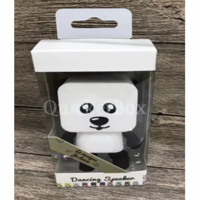

Actual
['<start>', 'ลำโพง', 'หมา', 'น้อย', 'นัก', 'เต้น', 'ลำโพง', 'บลูทูธ', 'พกพา', 'เจ้า', 'สุนัข', 'ขา', 'แดนซ์', 'สามารถ', 'ปรับ', 'การ', 'เต้น', 'ให้', 'ช้า', 'และ', 'เร็ว', 'ได้', 'ระดับ', 'คุณ', 'สม', 'บัต', 'เด่น', '<end>']

Predict
model_baseline_39 	 <start>แท่ชาลแท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่แท่
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้า
L91586292.jpg


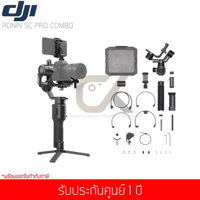

Actual
['<start>', 'ไม้', 'กัน', 'สั่น', 'สำหรับ', 'กล้อง', 'น้ำหนัก', 'เบา', 'เทคโนโลยี', 'กัน', 'สั่น', 'กล้อง', 'แบบ', 'แกน', 'หมุน', 'อิสระ', 'น้ำหนัก', 'เบา', 'เพียง', 'กิโลกรัม', 'พกพา', 'สะดวก', 'ใช้งาน', 'ได้', 'อย่าง', 'คล่องตัว', 'ทุก', 'สถานการณ์', 'น้ำหนัก', 'ของ', 'จะ', 'มี', 'ขนาด', 'เบา', 'ลง', 'กว่า', 'ออกแบบ', 'มา', 'สำหรับ', 'กล้อง', 'ได้', 'อย่าง', 'ลงตัว', 'รองรับ', 'การใช้งาน', 'ได้', 'อย่าง', 'เต็ม', 'ประสิทธิภาพ', 'ใน', 'อุปกรณ์', 'ที่', 'มี', 'น้ำหนัก', 'ไม่', 'เกิน', 'กิโลกรัม', 'ระบบ', 'กัน', 'สั่น', 'คุณภาพ', 'สูง', 'ให้', 'งาน', 'ของ', 'คุณ', 'ลื่นไหล', 'ไม่', 'มี', 'สะดุด', 'ต่อ', 'เนื่องใน', 'ทุก', 'ท่วงท่า', 'ของ', 'การใช้งาน', 'ระบบ', 'ล็อค', 'ติดตาม', 'ทุก', 'การเคลื่อนไหว', 'ตัวใหม่', 'ล่าสุด', 'มี', 'โหมด', 'อัตโนมัติ', 'เต็ม', 'รูปแบบ', 'การ', 'ใช้', 'ร่วมกับ', 'มือถือ', 'ใน', 'โหมด', 'พร้อม', 'ให้', 'คุณ', 'ควบคุม', 'การเคลื่อนไหว', 'อย่าง', 'มือโปร', 'ง่ายๆ', 'ด้วย', 'สมาร์ท', 'โฟน', 'คือ', 'ใช้', 'มือ', 'ถือเป็น', 'ตัวควบคุม', 'ทั้งหมด', 'มี', 'แก

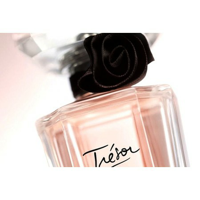

Actual
['<start>', 'กล่อง', 'ขาย', 'ใหม่', 'ซีล', 'เพียง', 'บาท', 'ส่ง', 'ฟรี', 'กลิ่น', 'ที่', 'ขาดไม่ได้', 'เลย', 'คือ', 'กลิ่นหอม', 'สดชื่น', 'ของ', 'เบอ', 'กา', 'มอ', 'ต', 'ที่มา', 'พร้อม', 'กลิ่น', 'หวาน', 'ละมุน', 'ของ', 'มัก', 'ส์', 'ดอก', 'ไว', 'โอ', 'เลท', 'และ', 'มะลิ', 'แอบ', 'ซ่อนกลิ่น', 'ส', 'ไป', 'ซี่', 'นิดๆ', 'ตาม', 'สไตล์', 'ลัง', 'โคม', 'เป็น', 'อีก', 'กลิ่น', 'ที่', 'หอม', 'สวย', 'หวาน', 'สะอาด', 'ใช้', 'ง่าย', '<end>']

Predict
model_baseline_39 	 <start>์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้า
L90361332.jpg


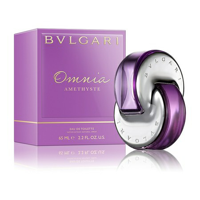

Actual
['<start>', 'น้ำหอม', 'ที่', 'มี', 'กลิ่นหอม', 'หวาน', 'อ่อน', 'ๆ', 'จาก', 'ดอกไม้', 'นานา', 'ชนิด', 'กลิ่น', 'เปิด', 'หวาน', 'ไม่', 'เหมือน', 'ใคร', 'เป็น', 'กลิ่น', 'เด่นชัด', 'และ', 'ได้', 'ความหวาน', 'ของ', 'ทำให้', 'กลิ่น', 'ไม่', 'ใส', 'นัก', 'แต่', 'แน่น', 'ๆ', 'ช่วง', 'กลาง', 'ให้', 'โทน', 'เต็มที่', 'ไป', 'กับ', 'และ', 'บ่งบอกถึง', 'ความ', 'เป็น', 'หญิง', 'และ', 'ยังมี', 'กลิ่น', 'ชา', 'ของ', 'ซ่อน', 'อยู่', 'แบบ', 'ค่อนข้าง', 'มิดชิด', 'นอกจากนี้', 'กลิ่น', 'ยัง', 'สะอาด', 'คล้าย', 'สบู่', 'ชวน', 'ให้', 'นึกถึง', 'ของ', '<end>']

Predict
model_baseline_39 	 <start>์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส์ส
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้า
L91501085.jpg


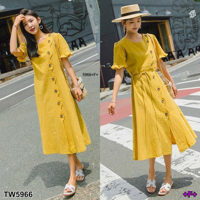

Actual
['<start>', 'แม็ก', 'ซี่', 'เด', 'รส', 'ติดกระดุม', 'แต่ง', 'หยัก', '<end>']

Predict
model_baseline_39 	 <start>รวมกันชื่อเสียงเรียงนามรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกัน
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้า
L91110810.jpg


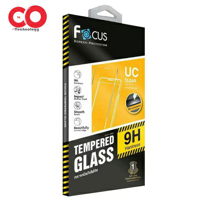

Actual
['<start>', 'กระจก', 'นิรภัย', 'โฟกัส', 'กระจก', 'นิรภัย', 'แบบ', 'ใส', 'ปกป้อง', 'หน้าจอ', 'มือถือ', 'ของ', 'คุณ', 'อย่าง', 'มั่นใจ', 'ด้วย', 'กระจก', 'นิรภัย', 'โฟกัส', 'ช่วย', 'ลด', 'ความเสี่ยง', 'จาก', 'การแตกร้าว', 'ของ', 'หน้าจอ', 'ของ', 'คุณ', 'ใน', 'เหตุ', 'การณ์', 'ที่', 'ไม่', 'คาดคิด', 'กระจก', 'นิรภัย', 'โฟกัส', 'ผ่าน', 'การเคลือบ', 'ด้วย', 'เทคโนโลยี', 'พิเศษ', 'ทำให้', 'สัมผัส', 'หน้าจอ', 'ได้', 'ลื่นไหล', 'ลด', 'รอยนิ้วมือ', 'คง', 'ความ', 'คมชัด', 'และ', 'สดใส', 'ของ', 'หน้าจอ', 'พร้อม', 'ดี', 'ไซ', 'น์', 'สวยงาม', 'ด้วย', 'ขอบ', 'ที่', 'โค้ง', 'มน', 'ป้องกัน', 'หน้าจอ', 'แตก', 'กระจาย', 'ลอก', 'ออก', 'ง่าย', 'ไม่', 'บาด', 'มือ', 'หนา', 'ทัช', 'ลื่น', 'ไม่', 'สะดุด', 'ภาพ', 'คมชัด', 'กระจก', 'นิรภัย', 'สี', 'สดใส', 'คง', 'ความสวยงาม', 'คงทน', 'แข็งแรง', 'กัน', 'รอยขีดข่วน', 'ติดตั้ง', 'และ', 'ใช้งาน', 'ง่าย', 'กว่า', 'ทั่วไป', 'ไม่', 'ทิ้ง', 'คราบ', 'กาว', 'ป้องกัน', 'หน้าจอ', 'แตก', 'กระจาย', 'สามารถ', 'ลอก', 'ฟิล์ม', 'ออก', 'เป็น', 'แผ่น', 'ได้', 'ไม่', 'บาด', '

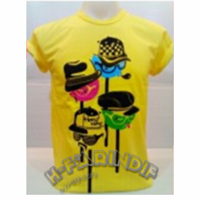

Actual
['<start>', 'เสื้อยืด', 'สกรีน', 'นูน', 'ลาย', 'อมยิ้ม', 'แร', 'พ', 'แบบ', 'ครอบครัว', 'ทีม', 'เด็กชาย', 'หญิง', '<end>']

Predict
model_baseline_39 	 <start>ขนมปังดื่่มอยขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปังขนมปัง
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้า
L91634803.jpg


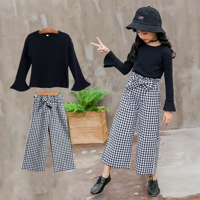

Actual
['<start>', 'เสื้อผ้า', 'เด็กผู้หญิง', 'เสื้อผ้า', 'เด็กโต', 'เสื้อแขนยาว', 'ปลาย', 'แขน', 'กระดิ่ง', 'ผ้า', 'คอ', 'ต', 'ตอน', 'ยืด', 'เนื้อ', 'นิ่ม', 'จัด', 'เซ็ต', 'คู่', 'กางเกงขายาว', 'เอว', 'ยืด', 'ผูก', 'เอว', 'โบว์', 'ลาย', 'สก็อต', 'กางเกง', 'สวย', 'ผ้าฝ้าย', 'ไม่', 'ยืด', 'เนื้อ', 'ดี', 'ขนาด', 'วัด', 'จาก', 'สินค้า', 'จริง', 'เอว', 'กางเกง', 'วัด', 'จาก', 'ไม่', 'ถึง', 'ยืด', 'ดึง', 'ยืด', 'พอดี', 'ๆ', 'ค่ะ', 'การ', 'กะ', 'ประมาณ', 'อายุ', 'น้อง', 'เทียบ', 'ตาม', 'เกณฑ์', 'มาตรา', 'ฐาน', 'กับ', 'ขนาด', 'สินค้า', 'จริง', 'หาก', 'ต้องการ', 'ความแม่นยำ', 'แนะนำ', 'ให้', 'วัด', 'จาก', 'เสื้อผ้า', 'ที่', 'น้อง', 'ใส่', 'อยู่', 'เพื่อ', 'พิจารณา', 'ไซ', 'ด์', 'ที่', 'เหมาะสม', 'ค่ะ', 'สินค้า', 'แต่ละ', 'แบบ', 'แจ้ง', 'ไซ', 'ด์', 'เท่ากัน', 'แต่', 'ขนาด', 'จริง', 'ต่างกัน', 'พิจารณา', 'จาก', 'ขนาด', 'จริง', 'ของ', 'แต่ละ', 'แบบ', '<end>']

Predict
model_baseline_39 	 <start>รวมกันชื่อเสียงเรียงนามรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรวมกันรว

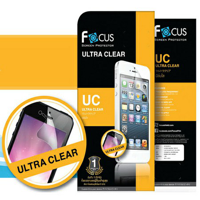

Actual
['<start>', 'ป้องกัน', 'รอยขีดข่วน', 'จาก', 'หน้าจอ', 'ถนอม', 'สายตา', 'พร้อม', 'ป้องกัน', 'รังสี', 'ได้', 'ถึง', 'ฟิล์ม', 'ญี่ปุ่น', 'เกรด', 'ติด', 'ง่าย', 'และ', 'ติด', 'ซ้ำ', 'ได้', 'ใช้', 'ซิลิโคน', 'เป็น', 'ส่วนประกอบ', 'ทำให้', 'ลอก', 'แล้ว', 'ไม่', 'ทิ้ง', 'คราบ', 'กาว', 'ขนาด', 'ของ', 'ฟิล์ม', 'พอดี', 'กับ', 'หน้าจอ', 'แต่ละ', 'รุ่น', 'ไม่', 'มี', 'คราบ', 'คล้าย', 'สี', 'รุ้ง', 'บน', 'เนื้อ', 'ฟิล์ม', 'ทำให้', 'หน้าจอ', 'ชัด', 'ใส', 'เป็น', 'ผู้ผลิต', 'ราย', 'แรก', 'และ', 'ราย', 'เดียว', 'ในประเทศ', 'ไทย', '<end>']

Predict
model_baseline_39 	 <start>การทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิการทำสมาธิ
model_LSTMRTlp_8 	 <start>มีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมีมี
model_BiLSTMRTlp_3 	 <start>ไฟหน้าปิดไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟหน้าไฟห

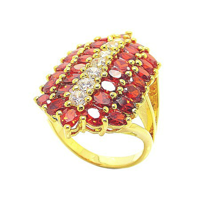

Actual
['<start>', 'ประดับ', 'ด้วย', 'พลอย', 'รูปไข่', 'สีแดง', 'โกเมน', 'ขนาด', 'กว้าง', 'มิ', 'ล', 'ยาว', 'มิ', 'ล', 'และ', 'เพชร', 'กลม', 'สี', 'ขาว', 'ใส', 'ขนาด', 'มิ', 'ล', 'ด้านหน้า', 'ความ', 'กว้าง', 'ของ', 'หน้า', 'แหวน', 'รวม', 'ตัวเรือน', 'และ', 'พลอย', 'เท่ากับ', 'ซม', 'ใช้', 'เทคนิค', 'งา', 'นข', 'อง', 'แท้', 'ชุบ', 'ทอง', 'ล้าง', 'เหงื่อ', 'และ', 'สิ่งสกปรก', 'ด้วย', 'น้ำ', 'ธรรมดา', 'เช็ค', 'ให้', 'แห้ง', 'ด้วย', 'ผ้า', 'ชา', 'มัว', 'ส์', 'หรือ', 'ผ้า', 'ที่', 'นุ่ม', 'หลังจาก', 'ล้างน้ำ', 'หลีกเลี่ยง', 'การ', 'ขัด', 'อย่าง', 'แรง', 'บน', 'เครื่องประดับ', 'ที่', 'มี่', 'พื้นผิว', 'บอบบาง', 'โดย', 'เฉพาะที่', 'เพชรพลอย', 'เก็บ', 'ใส่', 'ถุง', 'ซิป', 'หรือ', 'ถุง', 'ผ้า', 'เพื่อ', 'หลีกเลี่ยง', 'ความชื้น', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'ซม', 'เส้นผ่านศูนย์กลาง', 'แหวน', 'ซม', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'ซม', 'เส้นผ่านศูนย์กลาง', 'แหวน', 'ซม', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'ซม', 'เส้นผ่านศูนย์กลาง', 'แหวน', 'ซม', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'ซม', 'เส้นผ่านศูนย์กลาง', '

In [ ]:
# argmax
predict_caption() #1
predict_caption() #2
predict_caption() #3
predict_caption() #4
predict_caption() #5
predict_caption() #6
predict_caption() #7
predict_caption() #8
predict_caption() #9
predict_caption() #10

L91133017.jpg


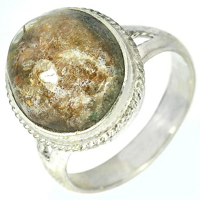

Actual
['<start>', 'ประเภท', 'สินค้า', 'เครื่องประดับ', 'เงิน', 'แท้', 'เครื่องประดับ', 'น้ำหนัก', 'กรัม', 'เครื่องประดับ', 'ขนาด', 'มิ', 'ล', 'ขนาด', 'อัญมณี', 'ควอตซ์', 'หิน', 'โป่งข่าม', 'รูปร่าง', 'แหวน', 'สี', 'จิวเวลรี่', 'เงิน', 'แท้', 'ความหมาย', 'ของ', 'แก้ว', 'โป่งข่าม', 'แก้ว', 'โป่งข่าม', 'เป็น', 'ภาษา', 'เหนือ', 'คำ', 'ว่า', 'แก้ว', 'มีความหมาย', 'บ่งบอก', 'ใน', 'ตัว', 'ชัดเจน', 'ว่า', 'หมายถึง', 'หิน', 'แก้ว', 'ใส', 'ตาม', 'ธรรมชาติ', 'จะ', 'ก่อตัว', 'ขึ้น', 'เป็น', 'ผลึก', 'อยู่', 'ใต้ดิน', 'หรือ', 'ใน', 'ถ้ำ', 'ที่', 'มี', 'ความ', 'เย็น', 'ชื่อ', 'แก้ว', 'โป่งข่าม', 'อัญมณี', 'ล้ำค่า', 'ของ', 'ล้านนา', 'ทั้ง', 'ประเภท', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม ขนาด กรัม
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว

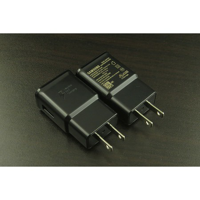

Actual
['<start>', 'สินค้า', 'ของ', 'ทาง', 'ร้าน', 'เป็น', 'ของแท้', 'ทั้งสิ้น', 'ไม่', 'ใช่', 'ของ', 'เลียนแบบ', 'คุณภาพ', 'สูง', 'หัว', 'ชาร์จ', 'ของแท้', 'สินค้า', 'จาก', 'โรงงาน', 'ผู้ผลิต', 'โดยตรง', 'สินค้า', 'รับประกัน', 'ปี', 'ทุก', 'รายการ', 'เปลี่ยน', 'ให้', 'ใหม่', 'ทันที', 'เช็ค', 'แล้ว', 'ไม่', 'แท้', 'ยินดี', 'คืนเงิน', 'สินค้า', 'ของแท้', 'สามารถ', 'วางใจ', 'ได้', 'ไม่', 'หลอกตา', 'แน่นอน', 'รายการสินค้า', 'หัว', 'ชาร์จ', 'กล่อง', 'สินค้า', 'คู่มือ', 'ต้อง', 'อยู่', 'ครบ', 'ไม่', 'รับ', 'เค', 'ลมสินค้า', 'จาก', 'การ', 'ใช้', 'ที่', 'ผิด', 'วิธี', 'เกิด', 'ความเสียหาย', 'เช่น', 'ตกน้ำ', 'กระแทก', 'หรือ', 'แตกหัก', 'ลูกค้า', 'ต้อง', 'เสีย', 'ค่า', 'จัดส่ง', 'ไป', 'กลับ', 'เอง', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ที่ มี ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร

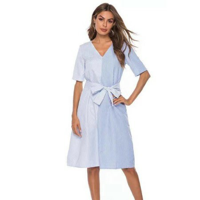

Actual
['<start>', 'เด', 'รส', 'แขน', 'สั้น', 'ลาย', 'ทาง', 'สี', 'ทู', 'โทน', 'มี', 'สาย', 'ผูก', 'เอว', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 ออม ปฏิกริยา ลงตัว มึนหัว ดื่่มอย ๆแมต เจ็ต ดื่่มอย ปฏิกริยา ลงตัว มึนหัว ร่อ่ย ดื่่มอย ๆแมต เจ็ต ดื่่มอย ปฏิกริยา ลงตัว มึนหัว ร่อ่ย ดื่่มอย ๆแมต เจ็ต ดื่่มอย
L91586118.jpg


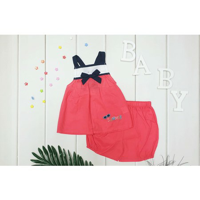

Actual
['<start>', 'ชุด', 'เซ็ท', 'สาวน้อย', 'สาย', 'ไขว้', 'สี', 'โอโรส', 'กางเกง', 'แต่ง', 'โบว์', 'ที่', 'อก', 'สี', 'กรม', 'ปัก', 'ลาย', 'น่ารัก', 'มาก', 'ค่ะ', 'กางเกง', 'ใส่', 'ยาง', 'ปลาย', 'ขา', 'แบบ', 'นิ่ม', 'ไม่', 'รัด', 'ไม่', 'บาด', 'ผิว', 'เด็ก', 'ค่ะ', 'ใส่', 'ไปเที่ยว', 'ไหน', 'ๆ', 'ก็', 'น่ารัก', 'สุด', 'ๆ', 'งาน', 'ผลิต', 'ใน', 'ไทย', 'คุณภาพ', 'งาน', 'ส่งออก', 'มี', 'เดือน', 'เดือน', 'อก', 'เอว', 'เดือน', 'อก', 'เอว', 'เดือน', 'อก', 'เอว', 'เดือน', 'อก', 'เอว', 'รูปถ่าย', 'จาก', 'สินค้า', 'จริง', 'เสื้อผ้า', 'เด็ก', 'ชุด', 'เด็ก', 'ชุด', 'ออกงาน', 'เด็ก', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ส่ง ร์ เด็ก เด็ก เด็ก ซม อายุ ชุด ไซ ร์ เด็ก ไซ ร์ เด็ก ซม อายุ ซม อายุ ชุด ไซ ร์ เด็ก ไซ ร์
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 ผู็ คุณนาย คุณนาย คุณน

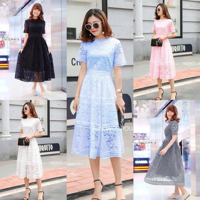

Actual
['<start>', 'แม็ก', 'ซี่', 'เด', 'รส', 'ลูกไม้', 'ลาย', 'ใหม่', 'ล่าสุด', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 ออม ปฏิกริยา ทางได้ เชิ็ต หัวไชเท้า ชาล คนเดียว เที่ยวเล่น ปักชำ ร่อ่ย ชื่อเสียงเรียงนาม ลงตัว มึนหัว ร่อ่ย เจ็ต ดื่่มอย ๆแมต เจ็ต ชาล คนเดียว เที่ยวเล่น ปักชำ ร่อ่ย ชื่อเสียงเรียงนาม
L90691500.jpg


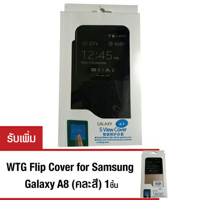

Actual
['<start>', 'เคส', 'ฝา', 'พับ', 'งาน', 'คุณภาพ', 'ยี่ห้อ', 'จาก', 'ฮ่องกง', 'ตัว', 'เคส', 'ใส่', 'บาง', 'ๆ', 'โชว์', 'หน้าจอ', 'นาฬิกา', 'รับสาย', 'คุย', 'ได้', 'ไม่ต้อง', 'เปิด', 'ฝา', 'ต้อง', 'ลง', 'เพิ่มเติม', 'งาน', 'สวย', 'บาง', 'ป้องกัน', 'มุม', 'เครื่อง', 'และ', 'หน้าจอ', 'ตั้ง', 'ได้', 'วัสดุ', 'เป็น', 'หนัง', 'คุณภาพดี', 'ข้างใน', 'เป็น', 'แบบ', 'เข็ง', 'เปิด', 'ปิด', 'สนิท', 'มั่นใจ', 'สามารถ', 'คุย', 'โทรศัพท์', 'ได้', 'ขณะ', 'ปิด', 'ฝา', 'มี', 'ช่อง', 'แสดง', 'สถานะ', 'ต่างๆ', 'ใช้งาน', 'ใน', 'แนวนอน', 'ได้', 'พับ', 'ตั้ง', 'ได้', 'รองรับ', 'ทนทาน', 'ต่อ', 'การใช้งาน', 'ไม่', 'เปื้อน', 'ง่าย', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 มี ขนาด ชาร์จ ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ชาร์จ ขนาด ชาร์จ ขนาด ชาร์จ ชาร์จ
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว 

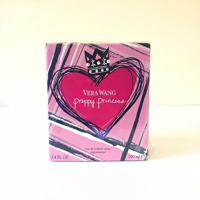

Actual
['<start>', 'น้ำหอม', 'แท้', 'พร้อม', 'กล่อง', 'ซีล', 'แร', 'งบ', 'รร', 'ดาล', 'ใจ', 'มาจาก', 'ตัว', 'น้ำหอม', 'สุด', 'เก๋า', 'ขวด', 'ของ', 'น้ำหอม', 'มี', 'ลาย', 'พิมพ์', 'เป็น', 'ลาย', 'สก็อต', 'สุด', 'คลาสสิค', 'ชื่อ', 'ของ', 'น้ำหอม', 'นั้น', 'ทำให้เกิด', 'หญิงสาว', 'ที่', 'มี', 'ความมั่นใจ', 'เป็น', 'ผู้นำ', 'และ', 'พร้อม', 'ที่จะ', 'ทำให้', 'ประทับใจ', 'เสมอ', 'ความอ่อนโยน', 'ความสวยงาม', 'และ', 'แฟชั่น', 'นำสมัย', 'เสมอ', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม น้ำหอม
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 ์ส เจ็ต ดื่่มอย สี่เหลี่ยมคางหมู เจ็ต ดื่่มอย สี่เหลี่ยมคางหมู อฟ สี่เหลี่ยมคางหมู เจ็ต 

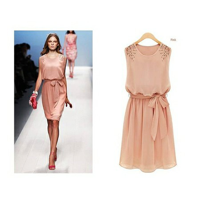

Actual
['<start>', 'ชุด', 'เด', 'รส', 'เรียบ', 'หรู', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 แสดงผล ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น
L91128304.jpg


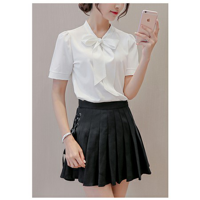

Actual
['<start>', 'เสื้อผ้า', 'ชีฟอง', 'คอ', 'ทำเป็น', 'ผ้า', 'ยาว', 'ผูก', 'โบ', 'ว', 'ค่ะ', '<end>']

Predict
model_baseline_20 	 ยู ซี ที เม ล่อน สบู่ บำรุง ผิวหน้า โลชั่น บำรุง ผิว ให้ ผิว กระจ่าง ใส ขึ้น และ ช่วย ลด เลือน ริ้วรอย ลด เลือน ริ้วรอย
model_LSTMRT_5 	 ส่ง ร์ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้ ลาย ดอกไม้
model_LSTMRTp_7 	 ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 สแตเลส ฉลาด ผู้กำหนด ทางได้ ปูอัด ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น
L91503867.jpg


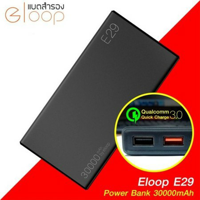

Actual
['<start>', 'แบต', 'สำรอง', 'ชาร์จ', 'เร็ว', 'ของแท้', 'วัสดุ', 'อลูมิเนียม', 'อย่าง', 'ดี', 'รองรับ', 'ชาร์จ', 'เร็ว', 'สำหรับ', 'ไอโฟน', 'รับประกัน', 'เดือน', 'แบต', 'สำรอง', 'เป็น', 'แบต', 'สำรอง', 'คุณภาพดี', 'รองรับ', 'ระบบ', 'การ', 'ชาร์จ', 'ไฟ', 'เข้า', 'และ', 'ปล่อย', 'กระแสไฟ', 'ออกแบบ', 'ที่', 'ทำ', 'ให้การ', 'ชาร์จ', 'แบตเตอรี่', 'ของ', 'คุณ', 'ได้', 'เร็ว', 'ยิ่งขึ้น', 'ตัว', 'แบต', 'สำรอง', 'สามารถ', 'ชาร์จ', 'ไฟ', 'เข้า', 'ได้', 'ใน', 'ระบบ', 'แต่', 'สามารถ', 'ใช้', 'ปล่อย', 'กระแสไฟ', 'ออก', 'ได้', 'ใน', 'ระบบ', 'ซึ่ง', 'ทำให้', 'เพิ่ม', 'ความเร็ว', 'ใน', 'การ', 'ชาร์จ', 'โทรศัพท์', 'ของ', 'คุณ', 'ได้', 'เร็ว', 'ยิ่งขึ้น', 'หลายเท่า', 'โดย', 'สามารถ', 'ชาร์จ', 'ไฟ', 'เข้า', 'มือถือ', 'ของ', 'คุณ', 'จาก', 'ใช้เวลา', 'เพียง', 'นาที', 'เท่านั้น', 'เร็ว', 'กว่า', 'การ', 'ชาร์จ', 'ธรรมดา', 'ถึง', 'เท่าตัว', 'แบต', 'สำรอง', 'ผลิต', 'จาก', 'พลาสติก', 'ผสม', 'อลูมิเนียม', 'มี', 'ความแข็งแรง', 'ทนทาน', 'ตัว', 'แบตเตอรี่', 'เป็น', 'แบบ', 'คุณภาพดี', 'ขนาด', 'และ', 'ตัว', 'แ

In [ ]:
# argmax
predict_caption() #1
predict_caption() #2
predict_caption() #3
predict_caption() #4
predict_caption() #5
predict_caption() #6
predict_caption() #7
predict_caption() #8
predict_caption() #9
predict_caption() #10

L91214413.jpg


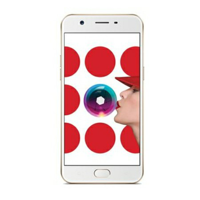

Actual
['<start>', 'ข้อมูล', 'เครือข่าย', 'ข้อมูล', 'ตัว', 'เครื่อง', 'ฟังก์ชั่น', 'มัลติมีเดีย', 'ประกัน', 'ศูนย์', 'ปี', 'ทุก', 'สาขา', 'ทั่วประเทศ', 'ใบ', 'รับประกัน', 'อยู่', 'ภายใน', 'กล่อง', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 ขนาด ชาร์จ ผลิต จาก น้ำหอม น้ำหอม น้ำหอม ของ กลิ่น ที่ น้ำหอม ที่ น้ำหอม ที่ น้ำหอม ที่ น้ำหอม น้ำหอม ที่ น้ำหอม น้ำหอม ที่ น้ำหอม
model_LSTMRTp_7 	 สินค้า ยาว สินค้า ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 ปลวก การนำทาง เชิ็ต โด่ง ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ๆแมช
L90631587.jpg


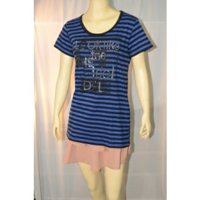

Actual
['<start>', 'เสื้อผ้า', 'แฟชั่น', 'แบรนด์', 'เนม', 'เสื้อยืด', 'แขน', 'สั้น', 'ลาย', 'ทาง', 'ขวาง', 'สีน้ำเงิน', 'ดำ', 'ลาย', 'ตัวอักษร', 'แต่ง', 'เลื่อม', 'เพชร', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 ส่ง ร์ เสื้อ แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น
model_LSTMRTp_7 	 สี แขน แขน แขน ยาว ยาว แขน ยาว แขน แขน ยาว แขน ยาว แขน ยาว แขน ยาว แขน ยาว แขน ยาว แขน ยาว
model_boat_9 	 ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร กดหัว ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร ลูกเล่น ตัวอักษร
L91042212.jpg


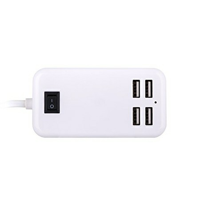

Actual
['<start>', 'นี้', 'เป็น', 'ผลิตภัณฑ์', 'ออกแบบ', 'ใหม่', 'ที่', 'สามารถ', 'ใช้', 'ใน', 'โอกาส', 'ที่', 'แตก', 'ต่างกัน', 'สำนัก', 'งานบ้าน', 'เดินทาง', 'เมื่อ', 'คุณ', 'ใช้งาน', 'คุณ', 'สามารถ', 'ตัด', 'ไฟ', 'โดย', 'ปุ่ม', 'เปิด', 'ปิด', 'ได้', 'อย่าง', 'ง่ายดาย', 'เมื่อ', 'ใช้งาน', 'ไฟ', 'แสดง', 'สถานะ', 'จะ', 'แสดง', 'เป็น', 'สีแดง', 'ชาร์จ', 'นี้', 'มี', 'พอร์ต', 'พอร์ต', 'และ', 'ต่อ', 'พอร์ต', 'สามารถ', 'เข้าถึง', 'สูงสุด', 'ทำงาน', 'ได้', 'เต็ม', 'พิกัด', 'กำลัง', 'ไฟ', 'วัตต์', 'มา', 'พร้อมกับ', 'นี่', 'เป็น', 'ของขวัญ', 'ที่', 'สมบูรณ์แบบ', 'สำหรับ', 'ครอบครัว', 'และ', 'เพื่อน', 'ของ', 'คุณ', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 สี ดำ สี ขาว สี ดำ สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี
model_LSTMRTp_7 	 สี สี สี สินค้า ยาว สี สินค้า สินค้า สินค้า ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 สนีย์ น้ำเหลือง สั่งจอง นั่ง ยีสต์ ทุกแห่ง อัลดีไฮด์ ลูกตุ้ม 

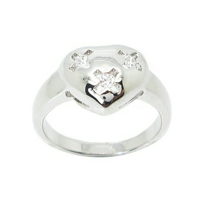

Actual
['<start>', 'ประดับ', 'ด้วย', 'เพชร', 'กลม', 'สี', 'ขาว', 'เม็ด', 'เล็ก', 'ใน', 'ช่อง', 'กากบาท', 'ด้านหน้า', 'แหวน', 'มี', 'ความ', 'กว้าง', 'ซม', 'วัด', 'ส่วน', 'ที่', 'ตัวเรือน', 'เป็น', 'หัวใจ', 'ใช้', 'เทคนิค', 'เดียว', 'กับ', 'งาน', 'ของแท้', 'ชุบ', 'ทองคำขาว', 'ล้าง', 'เห', 'งื่อ', 'และ', 'สิ่งสกปรก', 'ด้วย', 'น้ำ', 'ธรรมดา', 'เช็ค', 'ให้', 'แห้ง', 'ด้วย', 'ผ้า', 'ชา', 'มัว', 'ส์', 'หรือ', 'ผ้า', 'ที่', 'นุ่ม', 'หลังจาก', 'ล้างน้ำ', 'หลีกเลี่ยง', 'การ', 'ขัด', 'อย่าง', 'แรง', 'บน', 'เครื่องประดับ', 'ที่', 'มี่', 'พื้นผิว', 'บอบบาง', 'โดย', 'เฉพาะที่', 'เพชรพลอย', 'เก็บ', 'ใส่', 'ถุง', 'ซิป', 'หรือ', 'ถุง', 'ผ้า', 'เพื่อ', 'หลีกเลี่ยง', 'ความชื้น', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'มม', 'เส้น', 'ผ่าน', 'ศูนย์', 'กลา', 'งม', 'ม', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'มม', 'เส้น', 'ผ่าน', 'ศูนย์', 'กลา', 'งม', 'ม', 'ความ', 'ยาว', 'รอบ', 'นิ้ว', 'มม', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 สี ขาว สี ขาว ขนาด ขนาด 

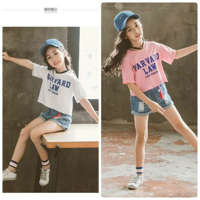

Actual
['<start>', 'รายละเอียด', 'เสื้อ', 'รอ', 'บอก', 'เอว', 'รอบ', 'แขน', 'แขน', 'ยาว', 'เสื้อ', 'ยาว', 'กางเกง', 'เอว', 'ยืด', 'สุด', 'สะโพก', 'ยาว', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 ส่ง ร์ แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น ลาย
model_LSTMRTp_7 	 สี สินค้า สินค้า สินค้า สินค้า สินค้า ยาว ยาว ยาว ยาว ยาว สินค้า ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 โน๊ตเล สเตนเลส เเบ กุ๊ด ถล ผู้กำหนด เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด เเบ กุ๊ด
L91291872.jpg


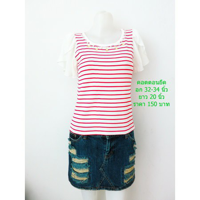

Actual
['<start>', 'อก', 'นิ้ว', 'ยาว', 'นิ้ว', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 สี ขาว แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น ลาย
model_LSTMRTp_7 	 สี แขน แขน แขน ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 โน๊ตเล สเตนเลส เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด
L91704805.jpg


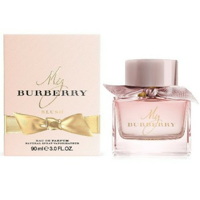

Actual
['<start>', 'ปริมาณ', 'มล', 'น้ำหอม', 'ที่', 'ผสมผสาน', 'กัน', 'ลงตัว', 'จนได้', 'กลิ่นหอม', 'อัน', 'เย้ายวน', 'ชวน', 'น่าหลงใหล', 'มอบ', 'กลิ่นหอม', 'สดชื่น', 'ทุกครั้งที่', 'ใช้', 'ด้วย', 'กลิ่น', 'ให้', 'คุณ', 'สัมผัส', 'กับ', 'กลิ่นหอม', 'ทั้ง', 'ระดับ', 'ให้', 'กลิ่นหอม', 'แต่', 'แฝง', 'ด้วย', 'ความสดชื่น', 'ราวกับ', 'อยู่', 'กลาง', 'สวนดอกไม้', 'เต็มไปด้วย', 'เสน่ห์', 'ความ', 'หอม', 'ที่', 'ยาก', 'จะ', 'ลืมเลือน', 'ด้วย', 'กลิ่น', 'ที่', 'เป็น', 'เอกลักษณ์', 'น้ำหอม', 'ประเภท', 'ที่', 'มี', 'ความ', 'เข้มข้น', 'ไม่', 'ได้', 'ผ่าน', 'การ', 'ผสม', 'ฉีด', 'เพียง', 'ครั้ง', 'เดียว', 'ก็', 'ให้', 'กลิ่น', 'ที่', 'หอม', 'ติด', 'ทน', 'ยาวนาน', 'ตลอด', 'ทั้งวัน', 'ปริมาณ', 'มล', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง กล่อง
model_LSTMRTp_7 	 สินค้า สินค้า สินค้า แขน ยาว ยาว ยาว ยา

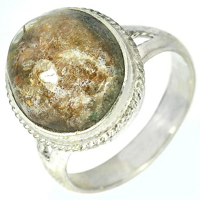

Actual
['<start>', 'ประเภท', 'สินค้า', 'เครื่องประดับ', 'เงิน', 'แท้', 'เครื่องประดับ', 'น้ำหนัก', 'กรัม', 'เครื่องประดับ', 'ขนาด', 'มิ', 'ล', 'ขนาด', 'อัญมณี', 'ควอตซ์', 'หิน', 'โป่งข่าม', 'รูปร่าง', 'แหวน', 'สี', 'จิวเวลรี่', 'เงิน', 'แท้', 'ความหมาย', 'ของ', 'แก้ว', 'โป่งข่าม', 'แก้ว', 'โป่งข่าม', 'เป็น', 'ภาษา', 'เหนือ', 'คำ', 'ว่า', 'แก้ว', 'มีความหมาย', 'บ่งบอก', 'ใน', 'ตัว', 'ชัดเจน', 'ว่า', 'หมายถึง', 'หิน', 'แก้ว', 'ใส', 'ตาม', 'ธรรมชาติ', 'จะ', 'ก่อตัว', 'ขึ้น', 'เป็น', 'ผลึก', 'อยู่', 'ใต้ดิน', 'หรือ', 'ใน', 'ถ้ำ', 'ที่', 'มี', 'ความ', 'เย็น', 'ชื่อ', 'แก้ว', 'โป่งข่าม', 'อัญมณี', 'ล้ำค่า', 'ของ', 'ล้านนา', 'ทั้ง', 'ประเภท', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 ขนาด กรัม สี เงิน ขนาด กรัม สี เงิน สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว สี ขาว ขนาด
model_LSTMRTp_7 	 สี แขน แขน แขน ยาว ยาว สี ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 วู๊ดดี้มัสค์ จิ๊ก ลูกเล่น เล็ก

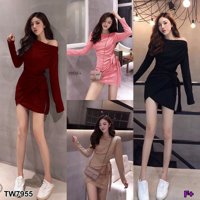

Actual
['<start>', 'เด', 'รส', 'สั้น', 'กระโปรง', 'ป้าย', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น ลาย
model_LSTMRTp_7 	 แขน แขน แขน แขน แขน ยาว ยาว ยาว แขน ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว ยาว
model_boat_9 	 เวิร์ท ไม้ฉาก เชิ็ต หัวไชเท้า เชิ็ต หัวไชเท้า เชิ็ต หัวไชเท้า เบอะ มึนหัว ดื่่มอย เวิร์ท ไม้ฉาก ดื่่มอย เวิร์ท ไม้ฉาก ดื่่มอย เวิร์ท ไม้ฉาก ดื่่มอย เวิร์ท ไม้ฉาก ชาล
L91437727.jpg


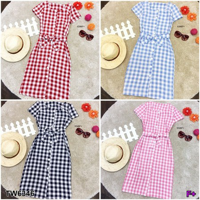

Actual
['<start>', 'เด', 'รส', 'สก็อต', 'ผูก', 'เอว', '<end>']

Predict
model_baseline_20 	 เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เส ง เ เขน ยาว ไซ ร์
model_LSTMRT_5 	 สี ขาว ผ้า คอ คอ แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น แขน สั้น
model_LSTMRTp_7 	 สี แขน แขน แขน ยาว ยาว ยาว ยาว แขน ยาว แขน แขน ยาว แขน แขน แขน แขน ยาว ยาว ยาว แขน ยาว ยาว
model_boat_9 	 โน๊ตเล สเตนเลส เเบ กุ๊ด ถล ผู้กำหนด โน๊ตเล สเตนเลส เเบ กุ๊ด ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด ถล ผู้กำหนด


In [ ]:
# beam4
predict_caption() #1
predict_caption() #2
predict_caption() #3
predict_caption() #4
predict_caption() #5
predict_caption() #6
predict_caption() #7
predict_caption() #8
predict_caption() #9
predict_caption() #10